In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.constants import c, Boltzmann
k = Boltzmann
from scipy.signal import fftconvolve
from scipy.signal.windows import hamming, blackman, kaiser, hann
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import csv
from funcs import read_iq_bin, notch_filter, gen_chirp_to_csv_rep, spectrogram_data, extract_signals_from_bin, read_complex_csv, gen_chirp_to_csv, gen_nlfm_to_csv
pulse_width = 5000
pulse_separation = 0
B = 12e6
fs = 25e6

def get_fft_data(complex_data, fs):
    fft_data = np.fft.fft(complex_data)
    fft_db = 20*np.log10(np.abs(fft_data))
    fft_freqs = np.fft.fftfreq(len(fft_data),1/fs)

    return fft_db, fft_freqs

result = gen_chirp_to_csv("../sweep_sim.csv", -B, B, pulse_width, pulse_separation, 1, 25e9)
result = gen_chirp_to_csv("sweep_doppler.csv", -11.e9, 12.1e9, pulse_width, pulse_separation, 1, 25e9)

font1 = 22
font2 = 16

# Baseband signal

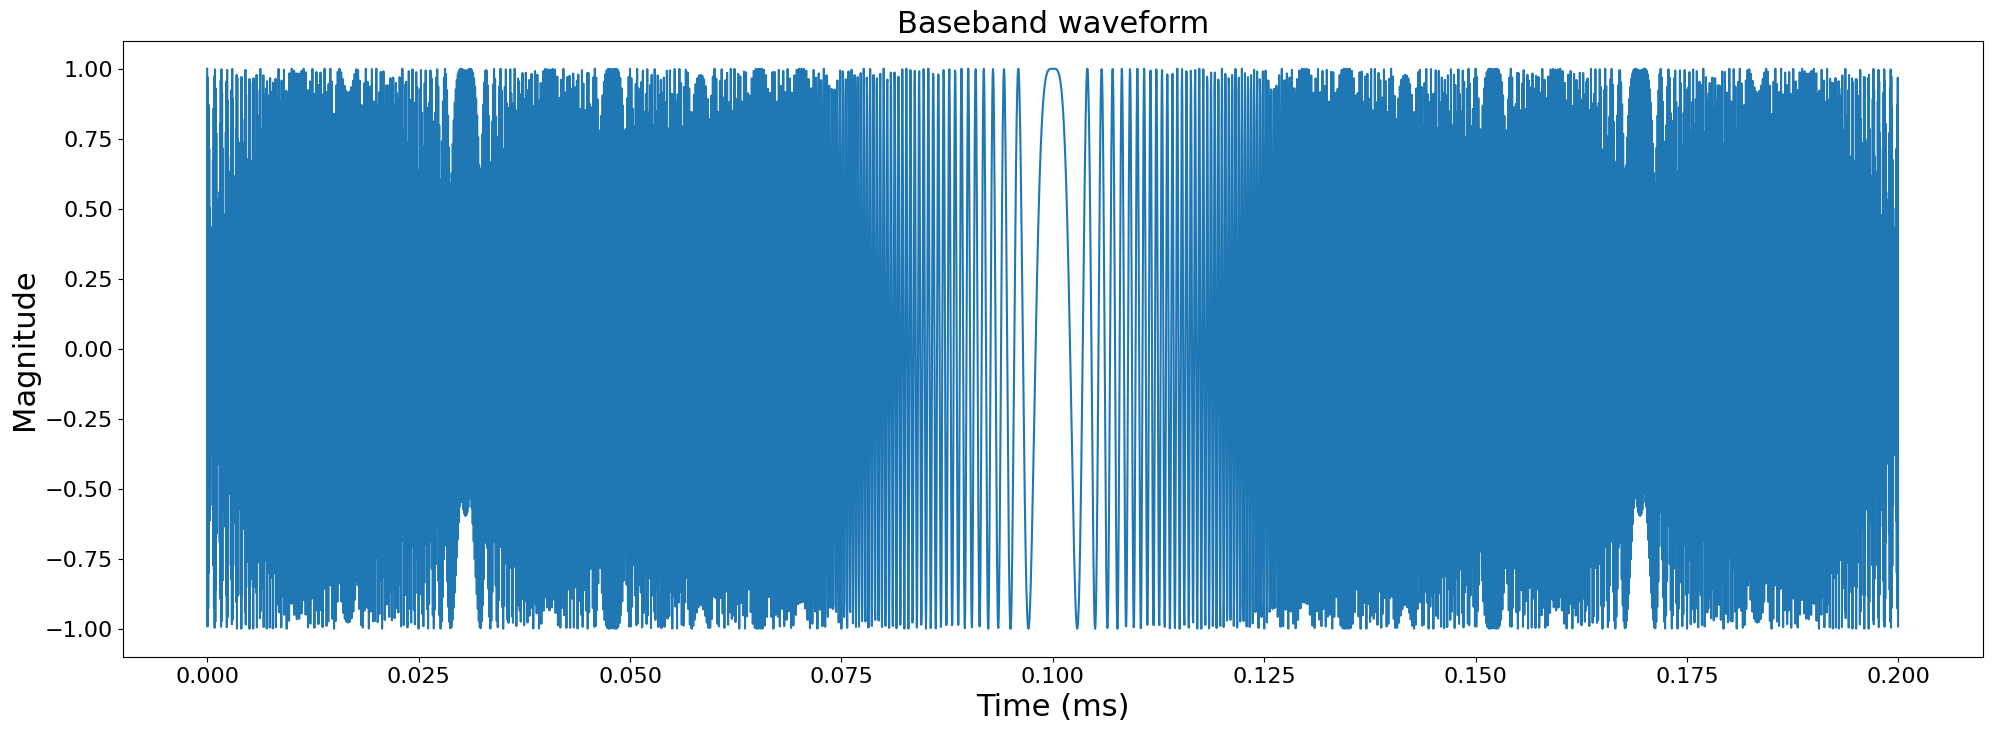

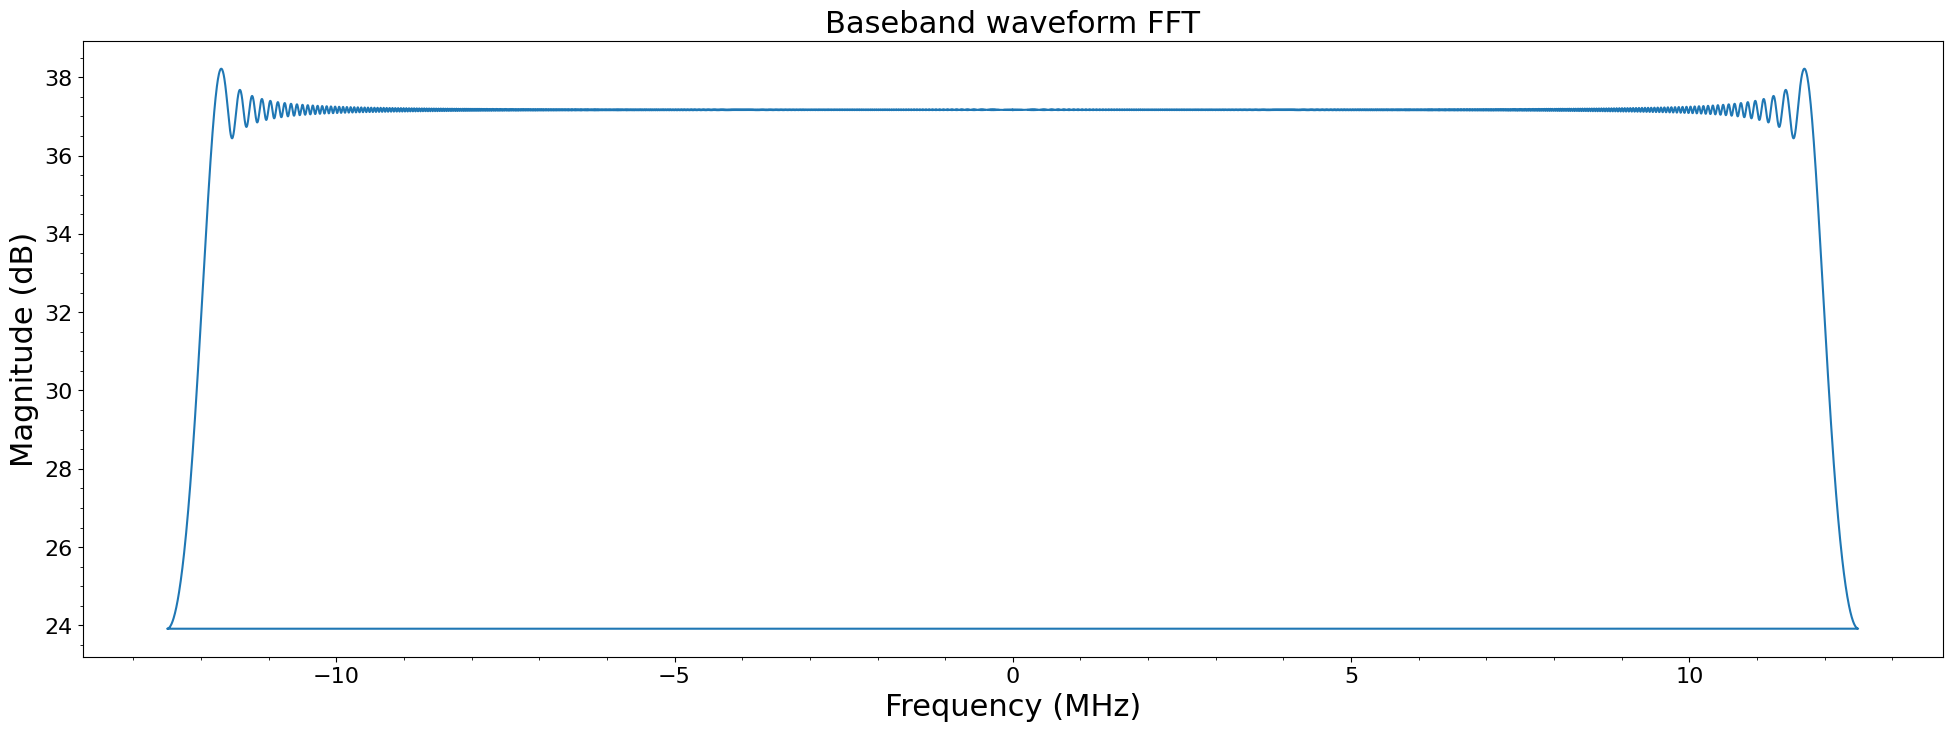

In [4]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]

seconds = np.arange(len(template_signal))/fs * 1000 # ms
plt.figure(figsize=(24,8))
plt.plot(seconds,template_signal)
plt.title("Baseband waveform", fontsize=22)
plt.xlabel("Time (ms)", fontsize=22)
plt.ylabel("Magnitude", fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

fft_db, fft_freqs = get_fft_data(template_signal,fs)
fft_freqs = fft_freqs/1000000 # MHz
plt.figure(figsize=(24,8))
plt.plot(fft_freqs,fft_db)
plt.title("Baseband waveform FFT", fontsize=font1)
plt.xlabel("Frequency (MHz)", fontsize=font1)
plt.ylabel("Magnitude (dB)", fontsize=font1)
plt.minorticks_on()
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.show()

# Homodyne

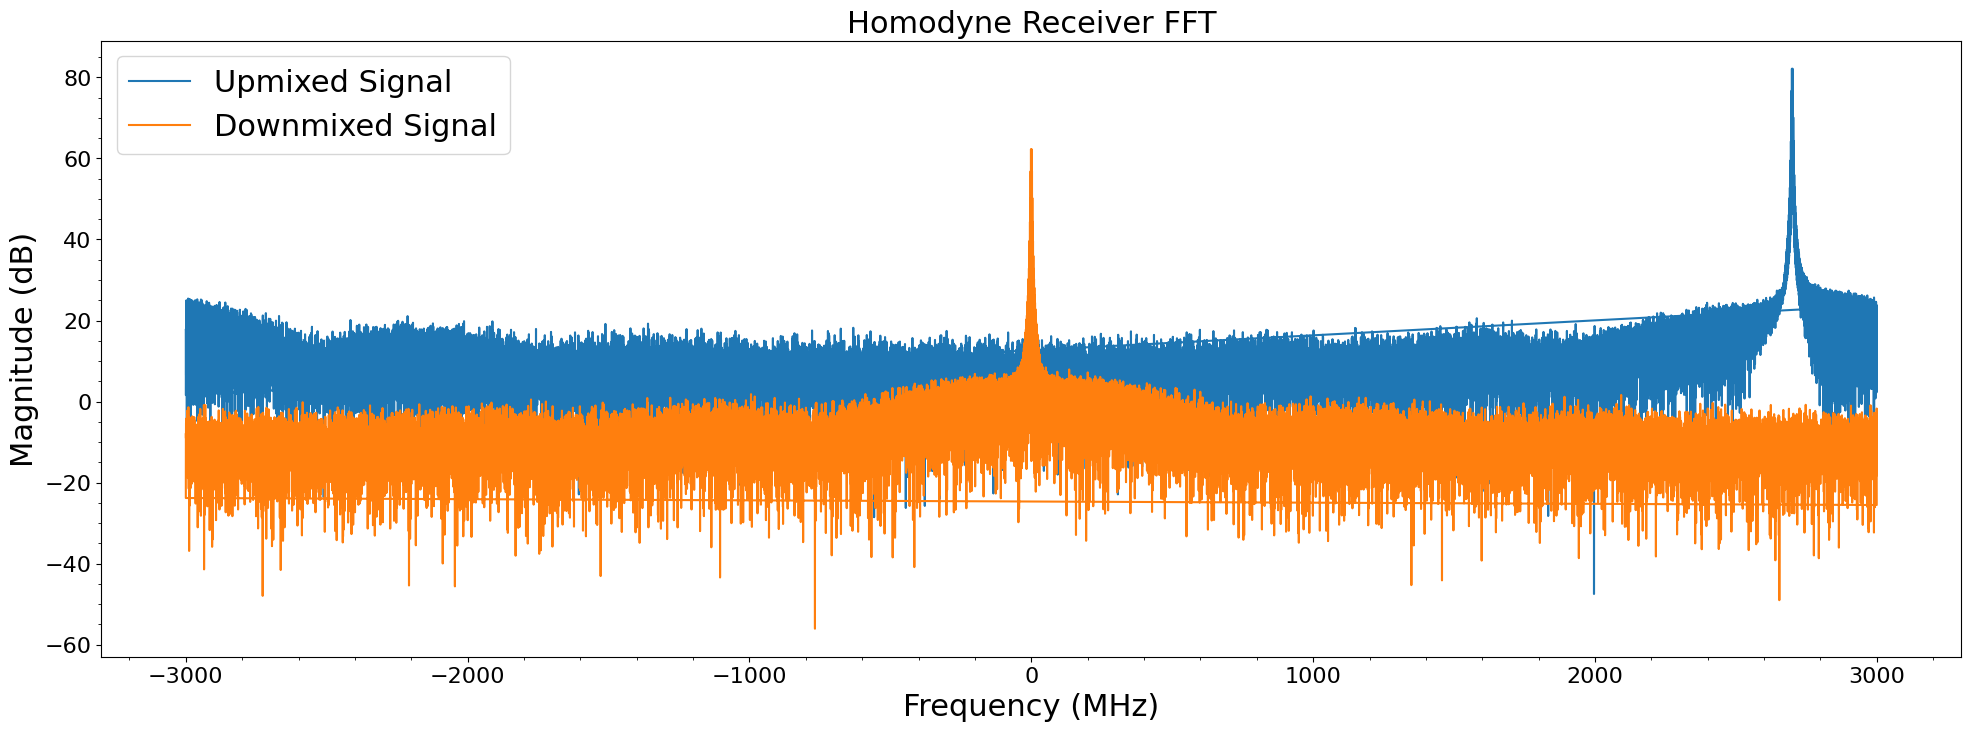

In [7]:
template_signal = read_complex_csv("../sweep_sim.csv")
template_signal = template_signal[0:pulse_width]
fs = 6e9


# Generate pulses
num_pulses=5
pulses_arr = []
for i in range(num_pulses):
    random_integer = np.random.randint(0, 10)
    zeros = np.zeros(random_integer).astype(np.complex128)
    pulses_arr.extend(zeros)
    pulses_arr.extend(template_signal)
pulses_arr = np.array(pulses_arr)

# LO frequency
t = np.arange(len(pulses_arr)) /fs
LO_freq = 2.7e9
I = np.cos(2 * np.pi * LO_freq * t)  # In-phase component (cosine)
Q = np.sin(2 * np.pi * LO_freq * t)  # Quadrature component (sine)
LO_arr = I + 1j*Q
noise_IQ = 0.01 * (np.random.randn(len(LO_arr)) + 1j * np.random.randn(len(LO_arr)))
LO_arr = LO_arr + noise_IQ

upmixed = LO_arr * pulses_arr
downmixed = 0.1 * upmixed * np.conj(LO_arr)

fft_upmixed, fft_freqs = get_fft_data(upmixed,fs)
fft_downmixed, fft_freqs = get_fft_data(downmixed,fs)
fft_freqs = fft_freqs/1000000 # MHz


plt.figure(figsize=(24,8))
plt.plot(fft_freqs,fft_upmixed, label="Upmixed Signal")
plt.plot(fft_freqs,fft_downmixed, label="Downmixed Signal")
plt.title("Homodyne Receiver FFT", fontsize=font1)
plt.xlabel("Frequency (MHz)", fontsize=font1)
plt.ylabel("Magnitude (dB)", fontsize=font1)
plt.legend(fontsize=font1)
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.minorticks_on()
plt.show()


# Matched Filter

Pt = 32.5dBm
Pr = -82.56960768095209dBm
atten: 3.1119974460730895e-12


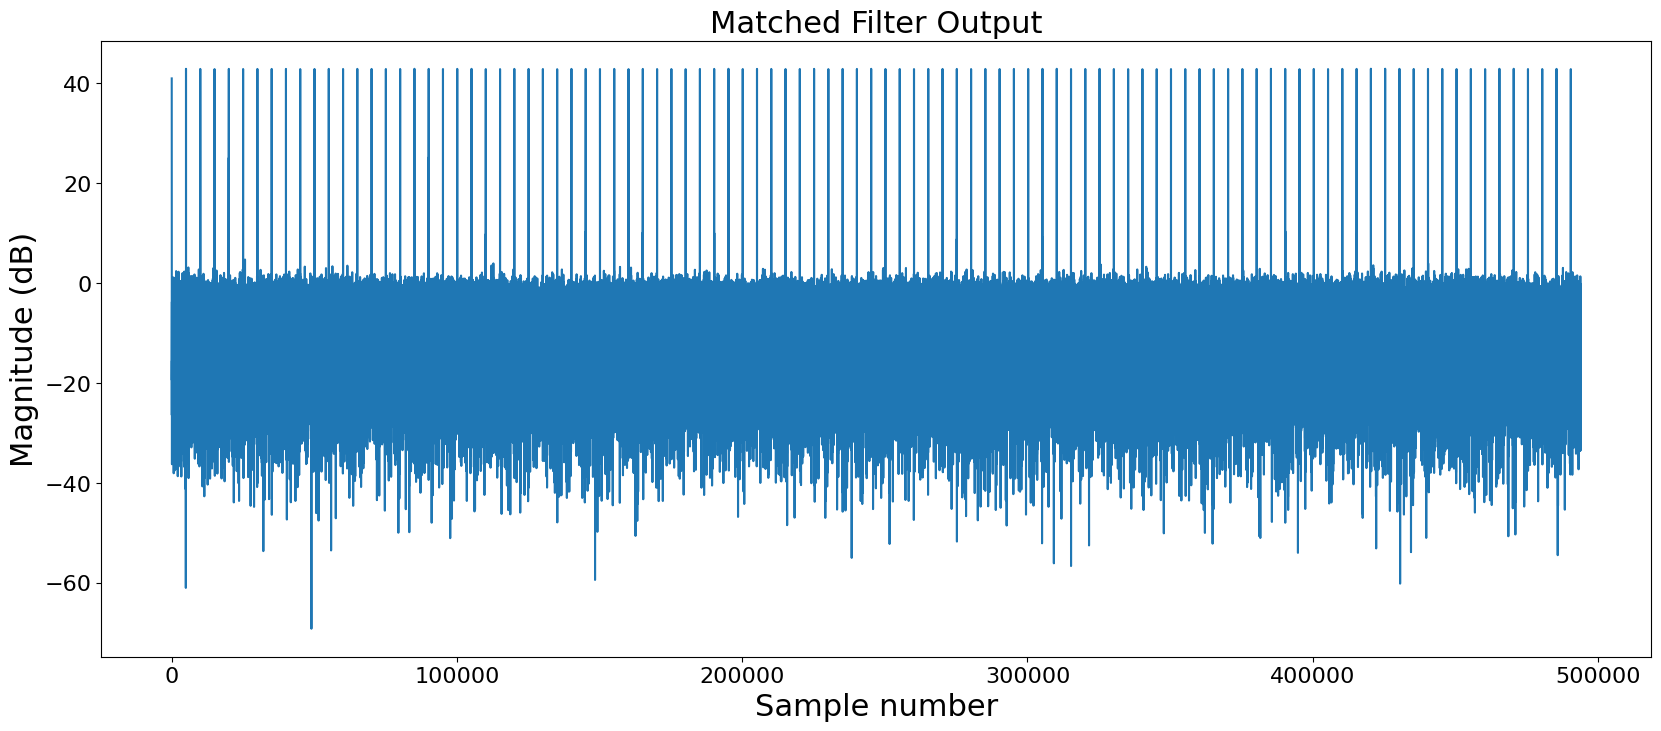

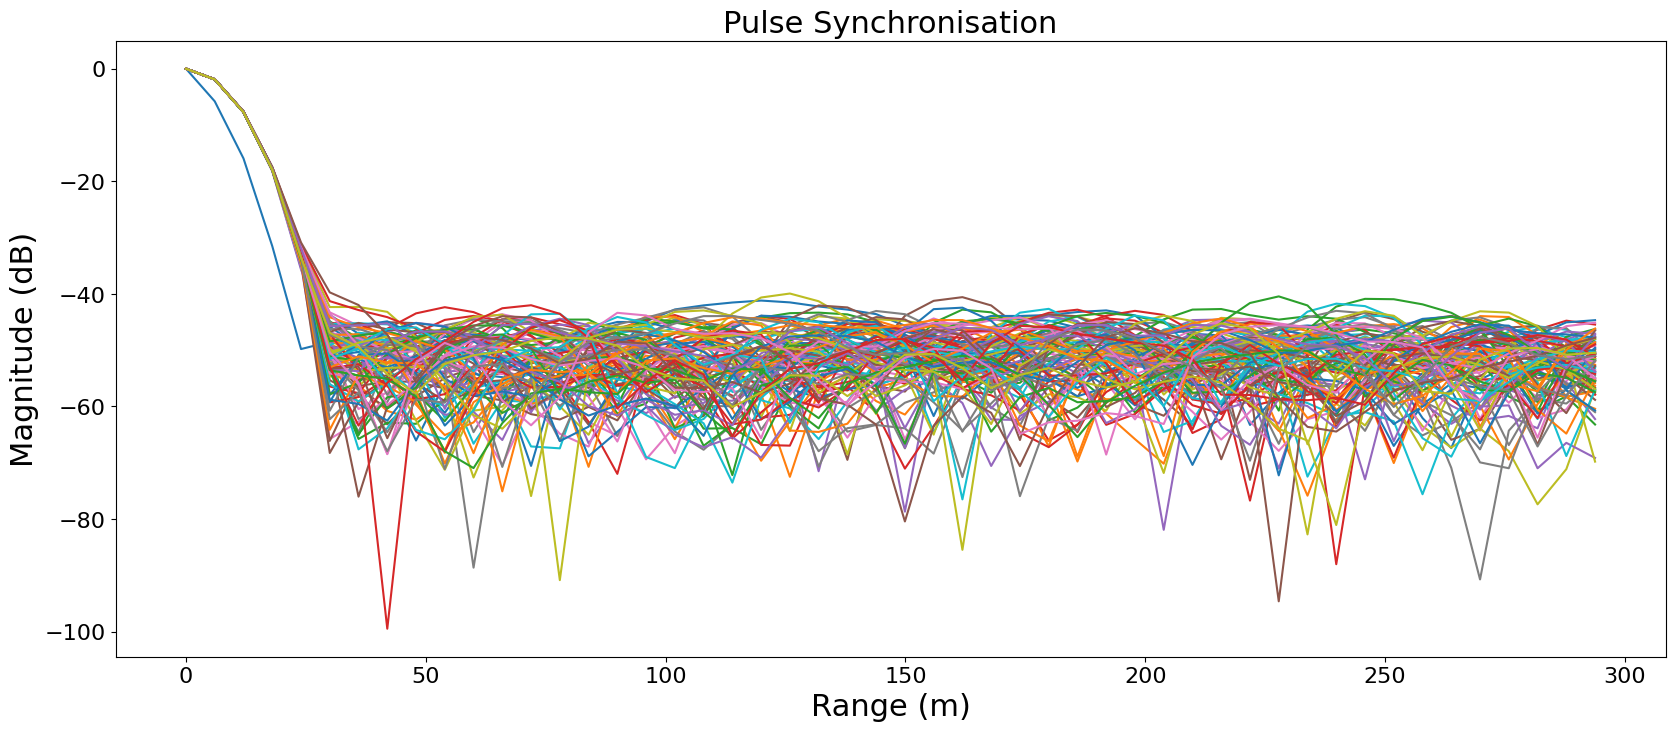

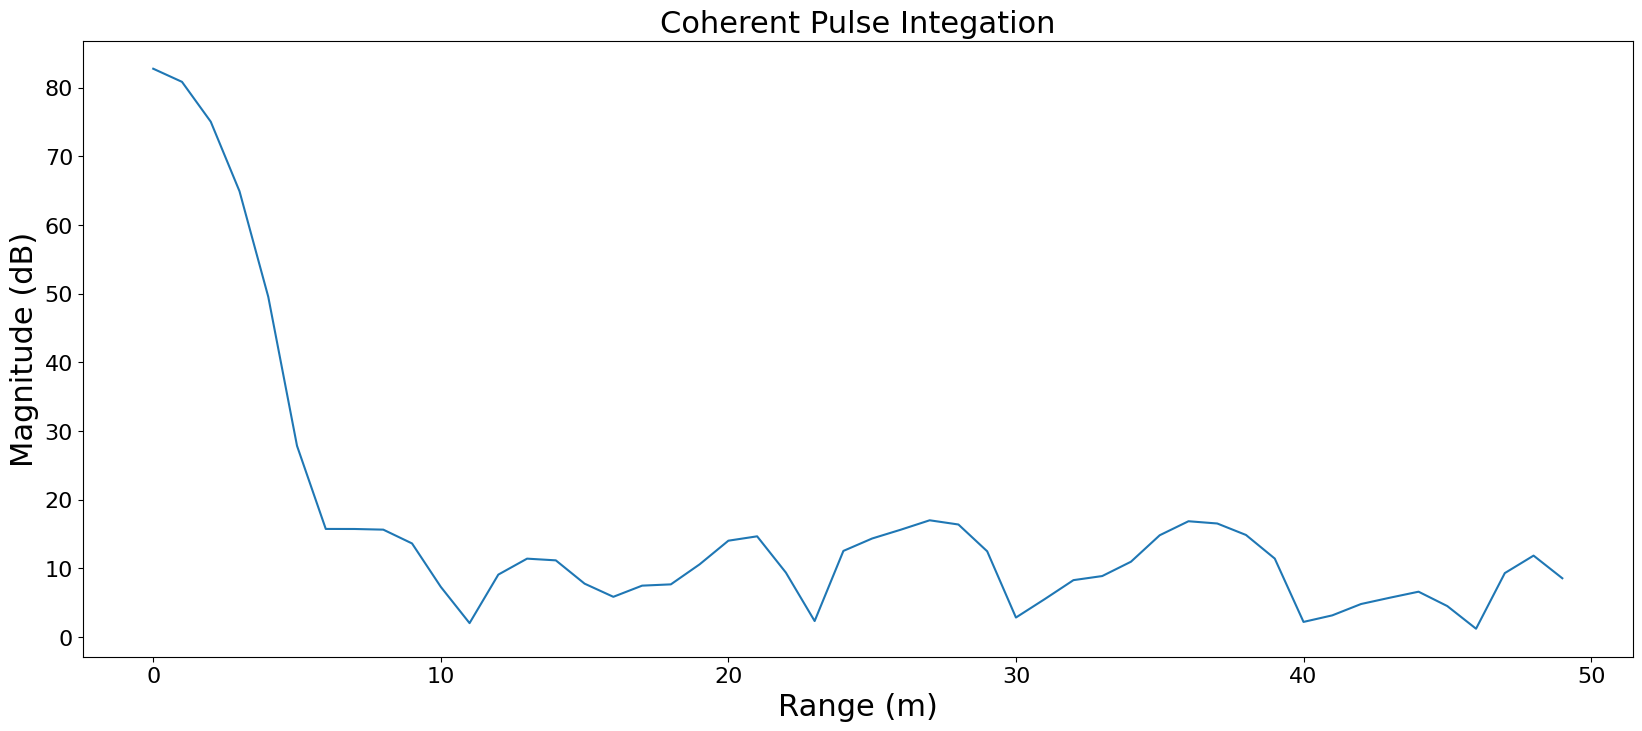

In [9]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]

fs = 25e6
R = 75
idx = 2*int(R/c * fs)
Pt_dbm = 12.5 + 20
Pt_lin = 10 ** (Pt_dbm / 10) * 0.001
Gr_db = 6
Gt_db = 6
Gr_lin = 10 ** (Gr_db / 10)
Gt_lin = 10 ** (Gt_db / 10)
fc = 2.7e9
lam = c/fc
rcs = 1
Pr_lin = (Pt_lin * Gr_lin * Gt_lin * lam**2 * rcs)/((4*np.pi)**3 * R**4)
Pr_db = 10*np.log10(Pr_lin)
print(f"Pt = {Pt_dbm}dBm")
print(f"Pr = {Pr_db+30}dBm")
atten = Pr_lin/Pt_lin
print(f"atten: {atten}")


# Generate pulses
num_pulses=100
pulses_arr = []
for i in range(num_pulses):
    random_integer = np.random.randint(0, 10)
    zeros = np.zeros(random_integer).astype(np.complex128)
    pulses_arr.extend(zeros)
    pulses_arr.extend(template_signal)
pulses_arr = np.array(pulses_arr)
pulses_arr = pulses_arr[0:num_pulses*pulse_width]
pulses_arr_xtalk = 0.1*pulses_arr

pulses_arr_shifted = np.zeros_like(pulses_arr)
pulses_arr_shifted[idx:] = atten*pulses_arr[:-idx]
signal_with_refl = pulses_arr_xtalk + pulses_arr_shifted
noise_IQ = 0.01 * (np.random.randn(len(signal_with_refl)) + 1j * np.random.randn(len(signal_with_refl)))
signal_with_refl = signal_with_refl + noise_IQ

matched_filter = np.conjugate(template_signal[::-1])
#window = hamming(len(matched_filter))  # Choose the appropriate window function
window = kaiser(len(matched_filter), 20, sym=True)  # Choose the appropriate window function
matched_filter = matched_filter * window  # Apply the window
xcorr_data = fftconvolve(signal_with_refl, matched_filter, mode='full')
xcorr_data = xcorr_data[5000:-6000] # Artifact at start from mode=full

plt.figure(figsize=(20,8))
plt.plot(20*np.log10(np.abs(xcorr_data)))
plt.title("Matched Filter Output", fontsize=font1)
plt.xlabel("Sample number", fontsize=font1)
plt.ylabel("Magnitude (dB)",fontsize=font1)
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.show()

# Pulse synchronisation
plt.figure(figsize=(20,8))
ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:50]
pulse_sum = np.zeros(50).astype(np.complex128)
while (len(xcorr_data)>0):
    max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
    xcorr_data_plot = xcorr_data[max_idx:max_idx+pulse_width]
    xcorr_data_plot = xcorr_data_plot[0:50]
    if (len(xcorr_data_plot)==50):
        plt.plot(ranges,20*np.log10(np.abs(xcorr_data_plot/np.max(xcorr_data_plot))))
        pulse_sum += xcorr_data_plot
        xcorr_data = xcorr_data[pulse_width+pulse_separation:]
    else:
        break

plt.title("Pulse Synchronisation", fontsize=font1)
plt.xlabel("Range (m)", fontsize=font1)
plt.ylabel("Magnitude (dB)", fontsize=font1)
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.show()

# Coherent pulse integration
plt.figure(figsize=(20,8))
plt.plot(20*np.log10(np.abs(pulse_sum)))
plt.title("Coherent Pulse Integation", fontsize=font1)
plt.xlabel("Range (m)", fontsize=font1)
plt.ylabel("Magnitude (dB)", fontsize=font1)
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.show()

# Reflection Friis

For distance 25
Pr = -53.990857425716456dBm
atten: 1.4978113896195641e-05
--------
For distance 50
Pr = -66.0320572522757dBm
atten: 3.7445284740489103e-06
--------
For distance 75
Pr = -73.07570761450295dBm
atten: 1.6642348773550714e-06
--------
For distance 100
Pr = -78.07325707883496dBm
atten: 9.361321185122276e-07
--------
Noise power 9.60931704e-14 linear, -130.17307477711205dB
Theoretical max range 356.858004349278m


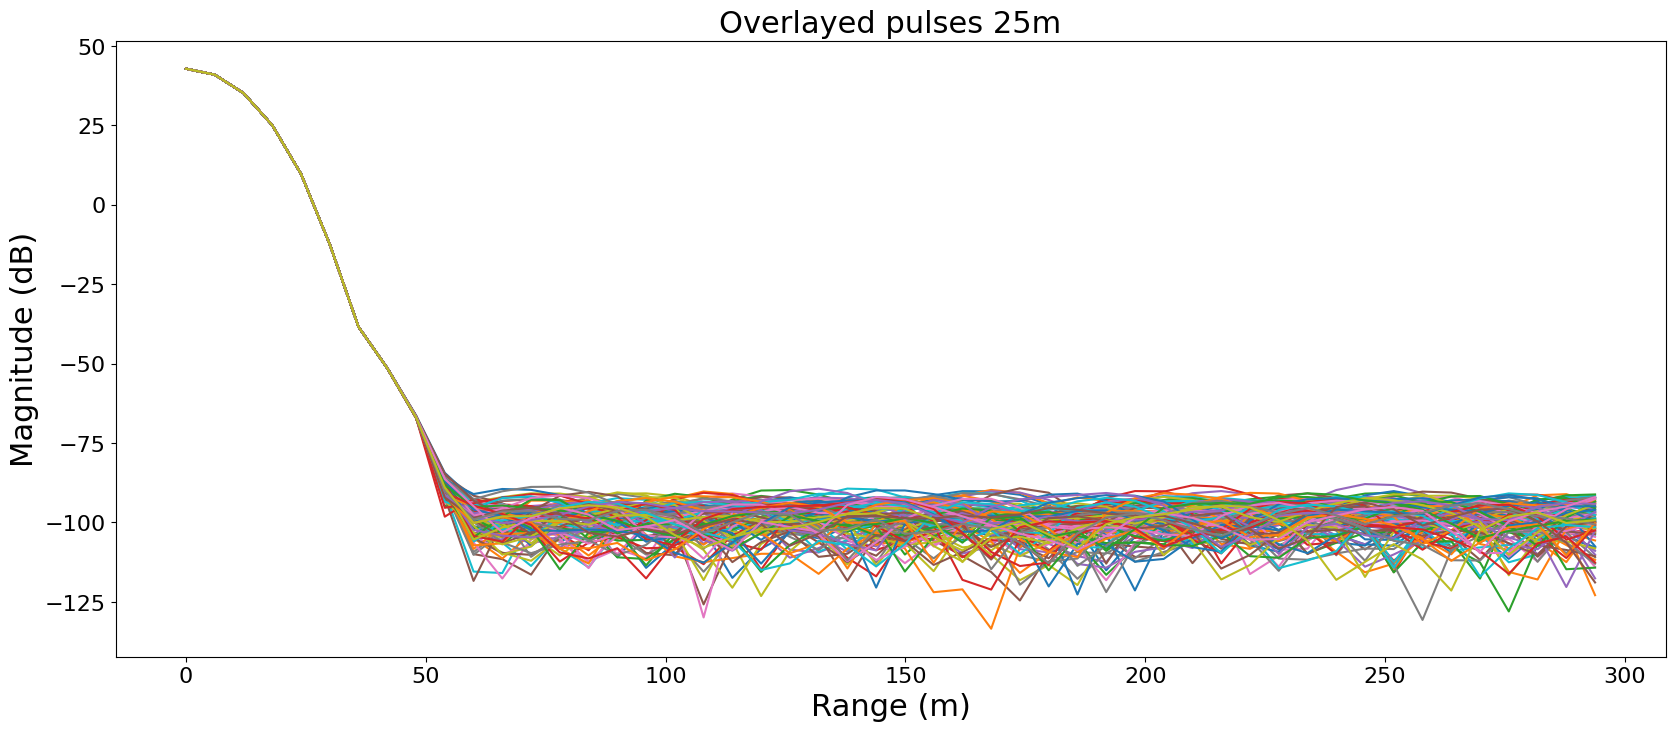

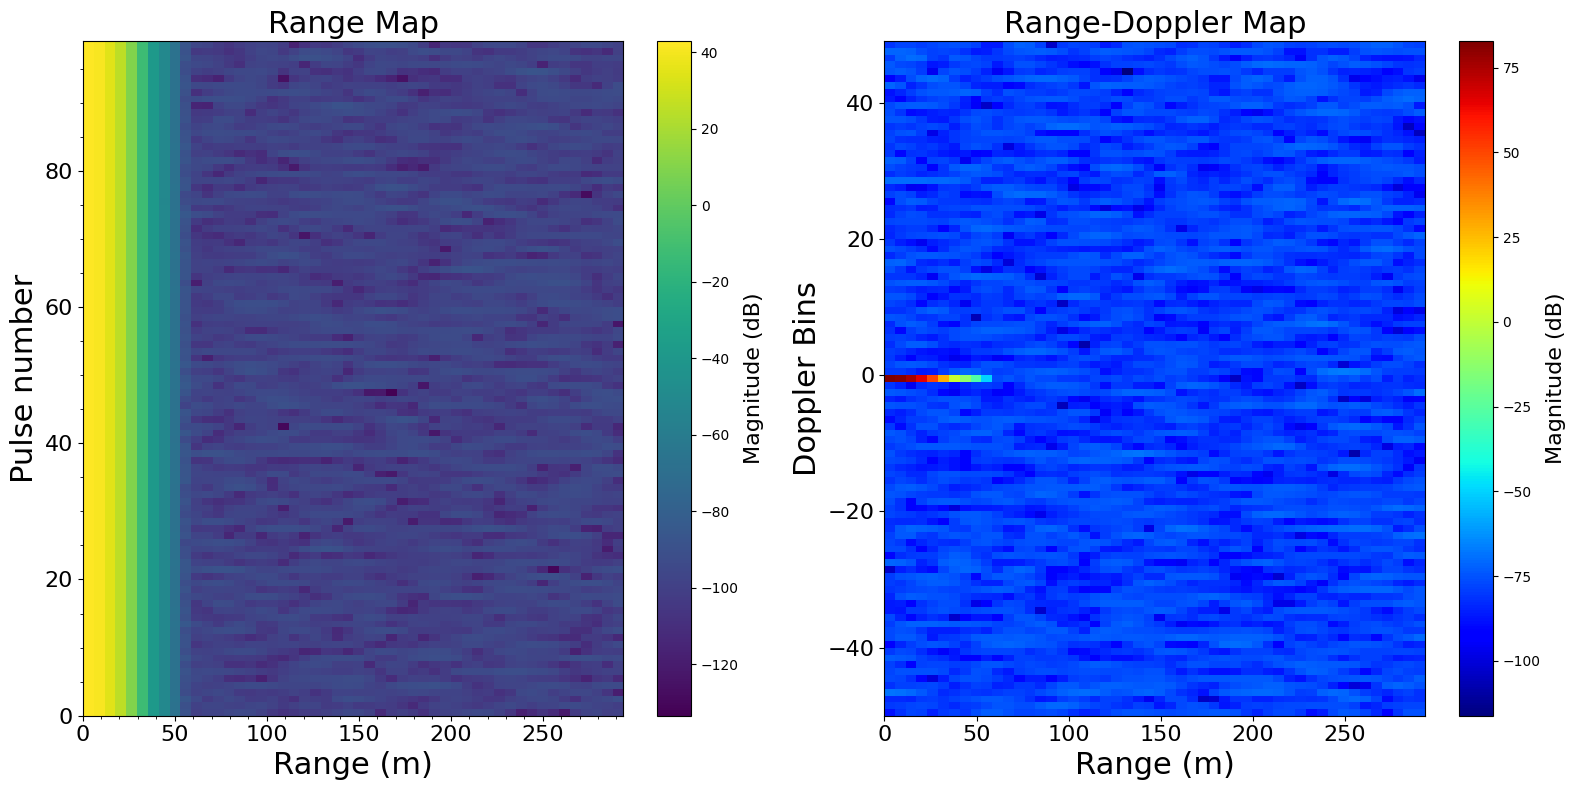

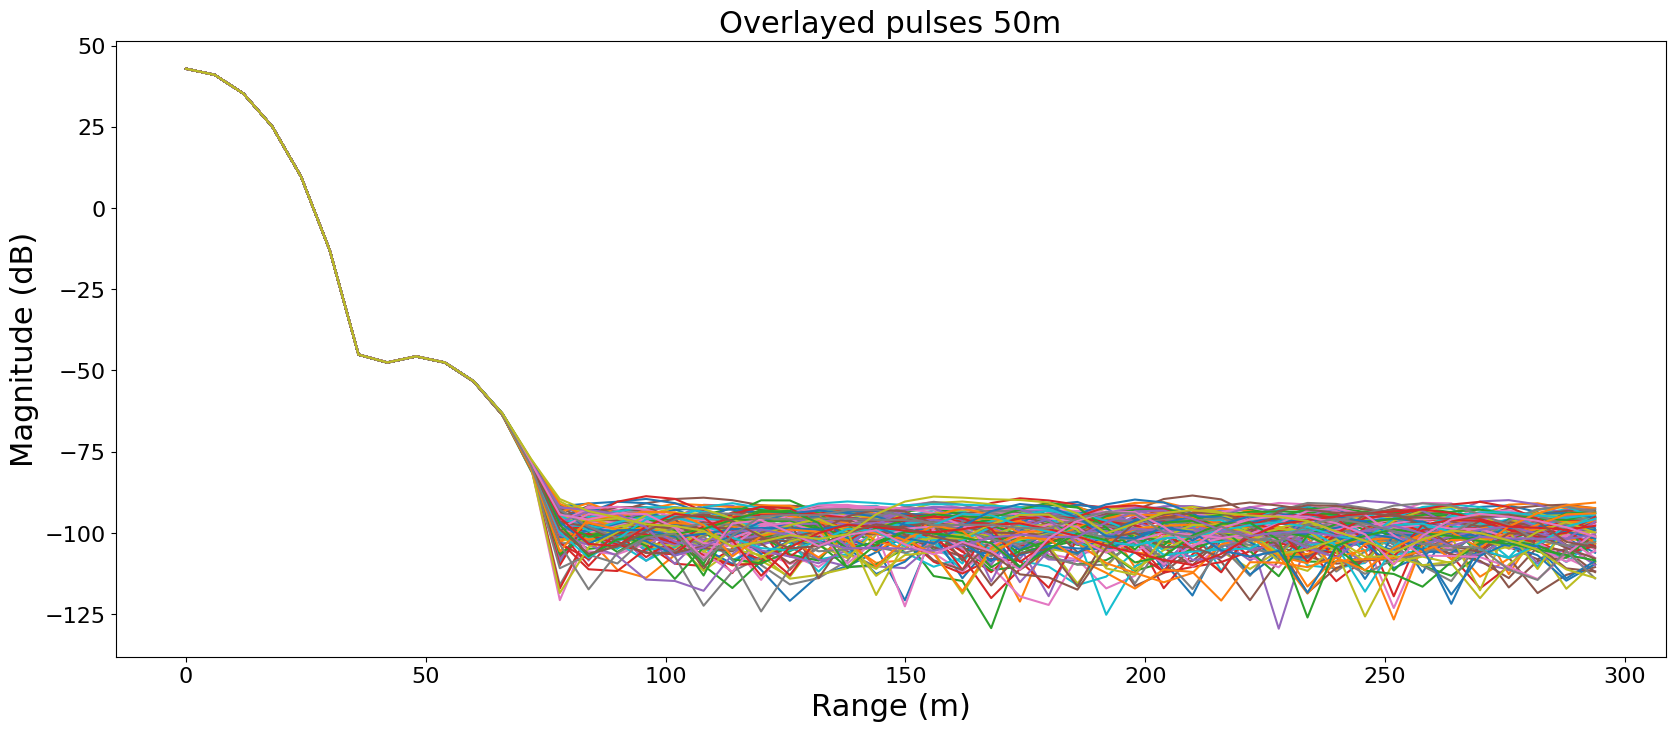

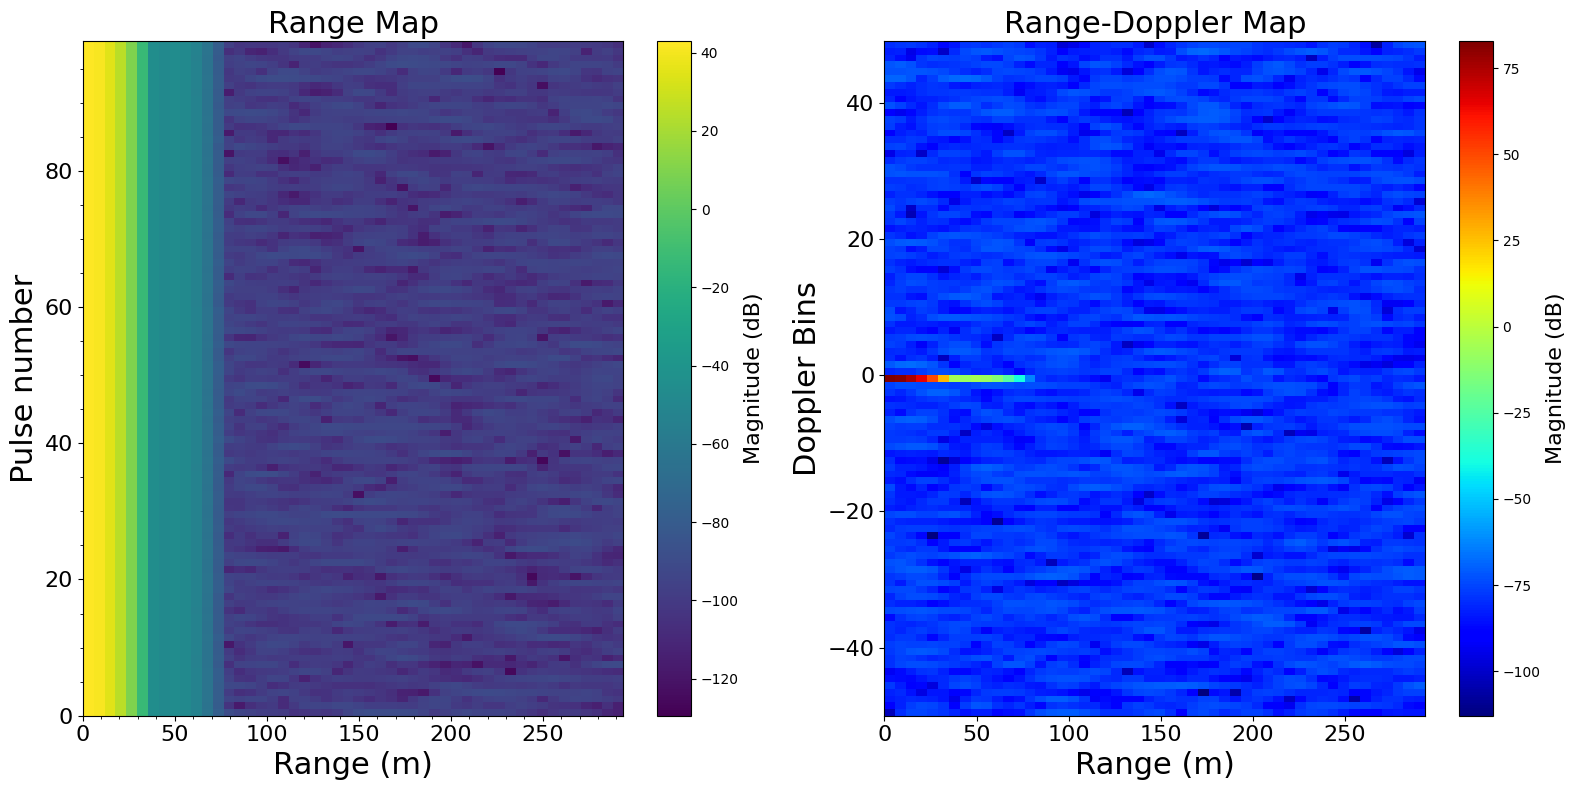

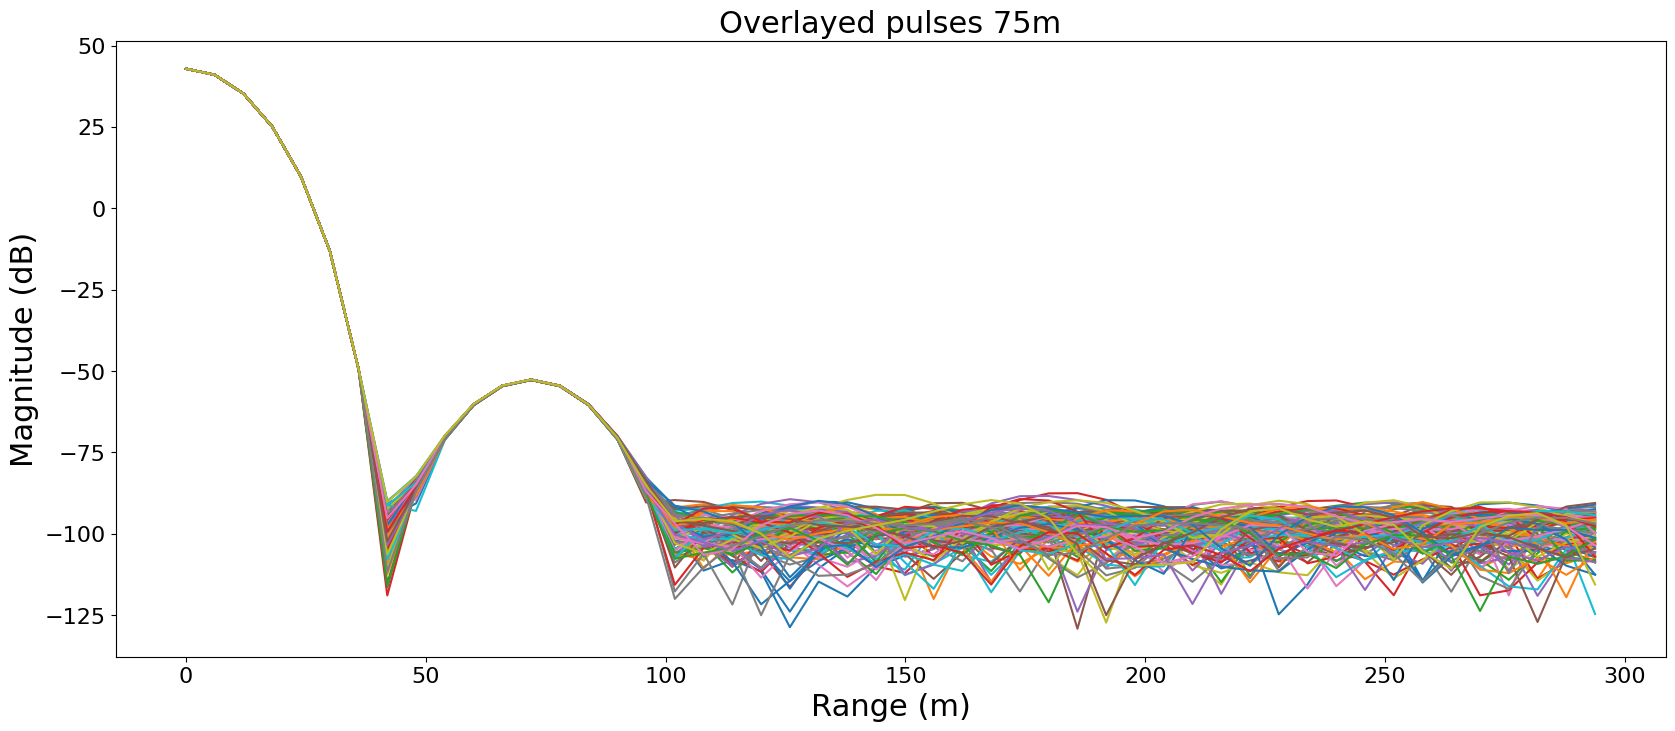

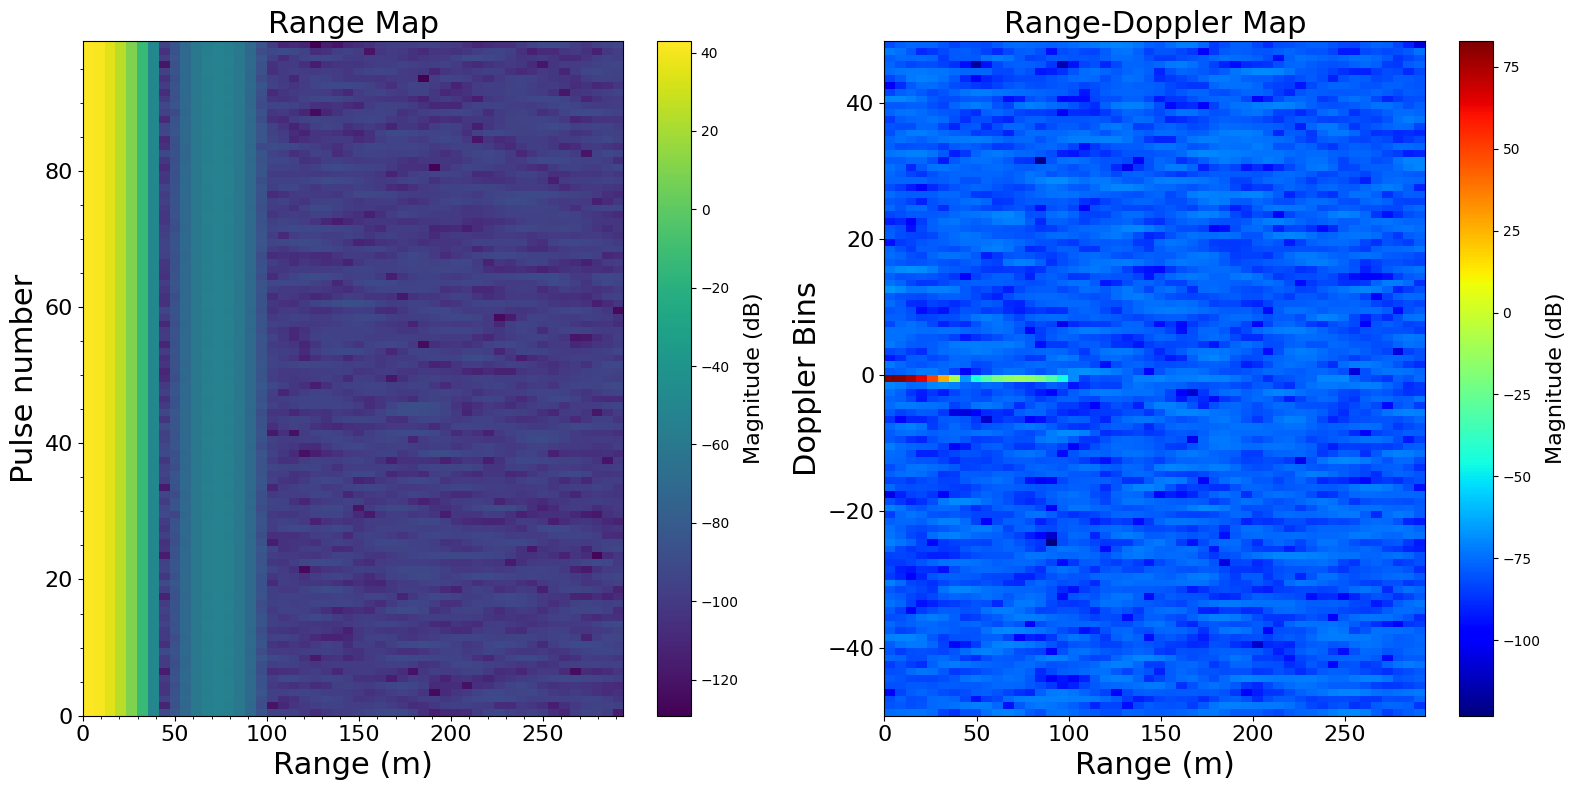

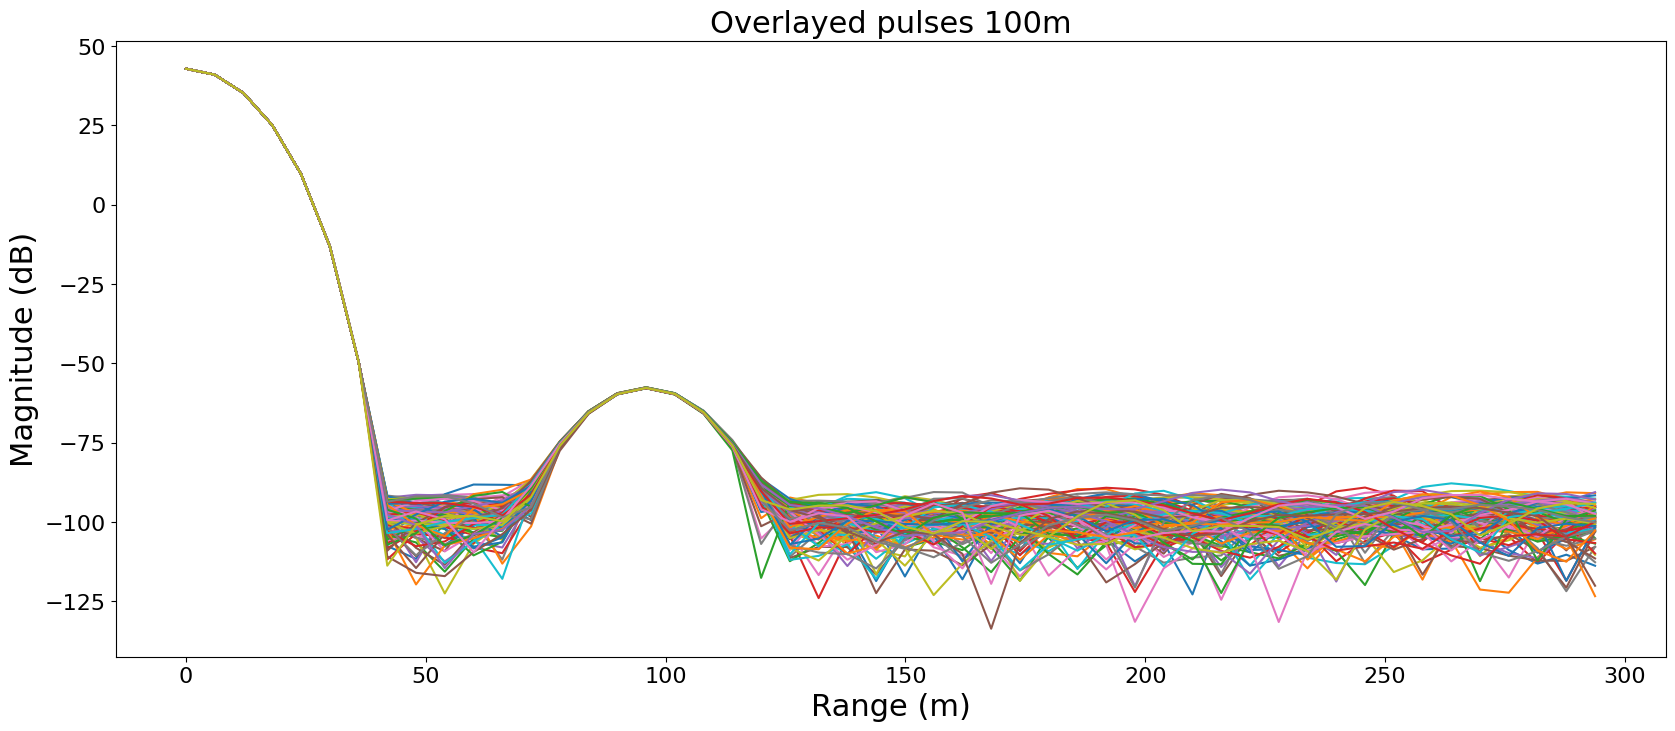

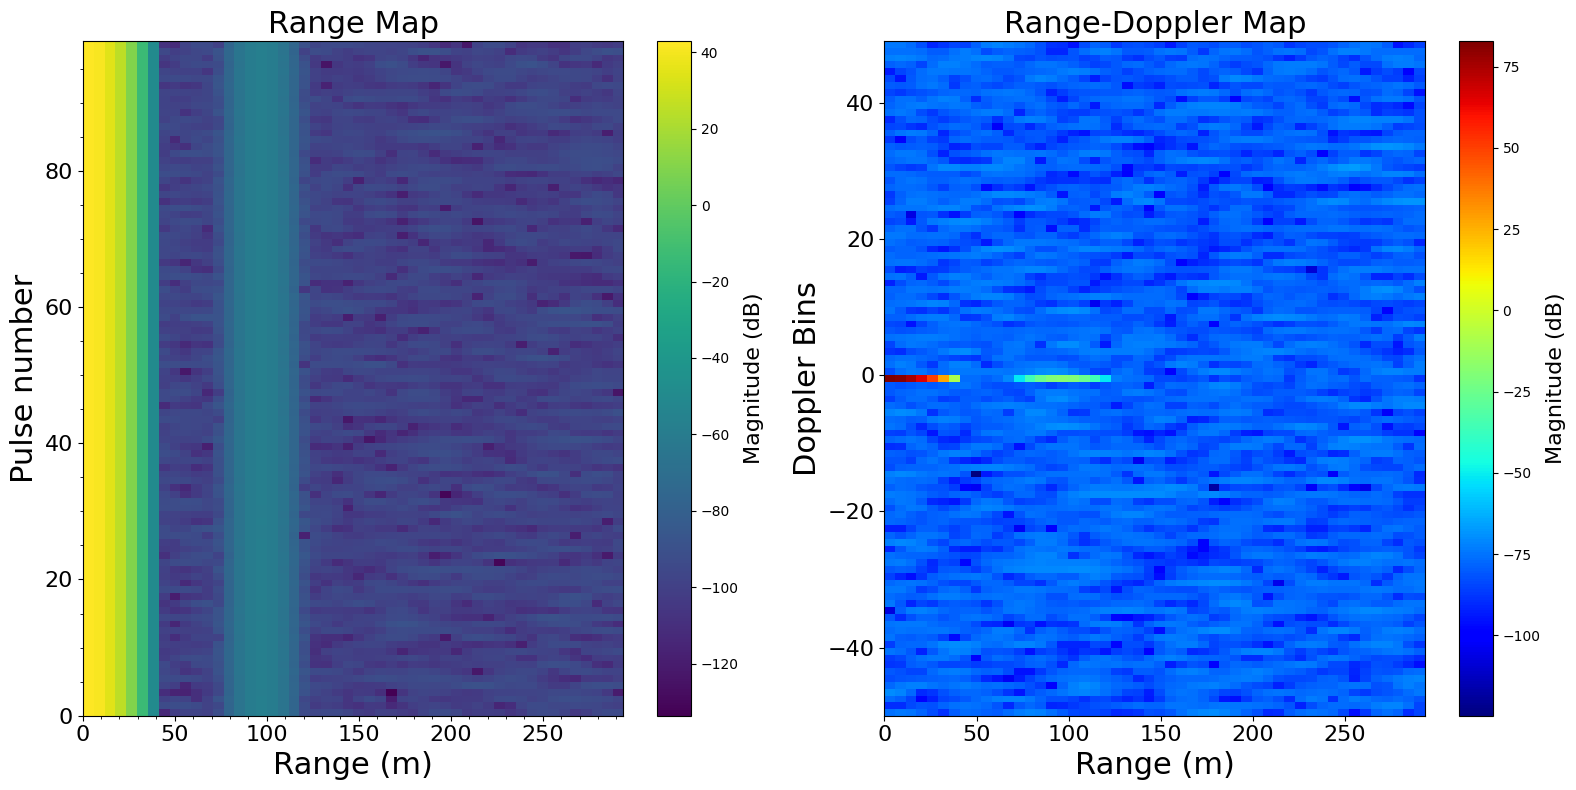

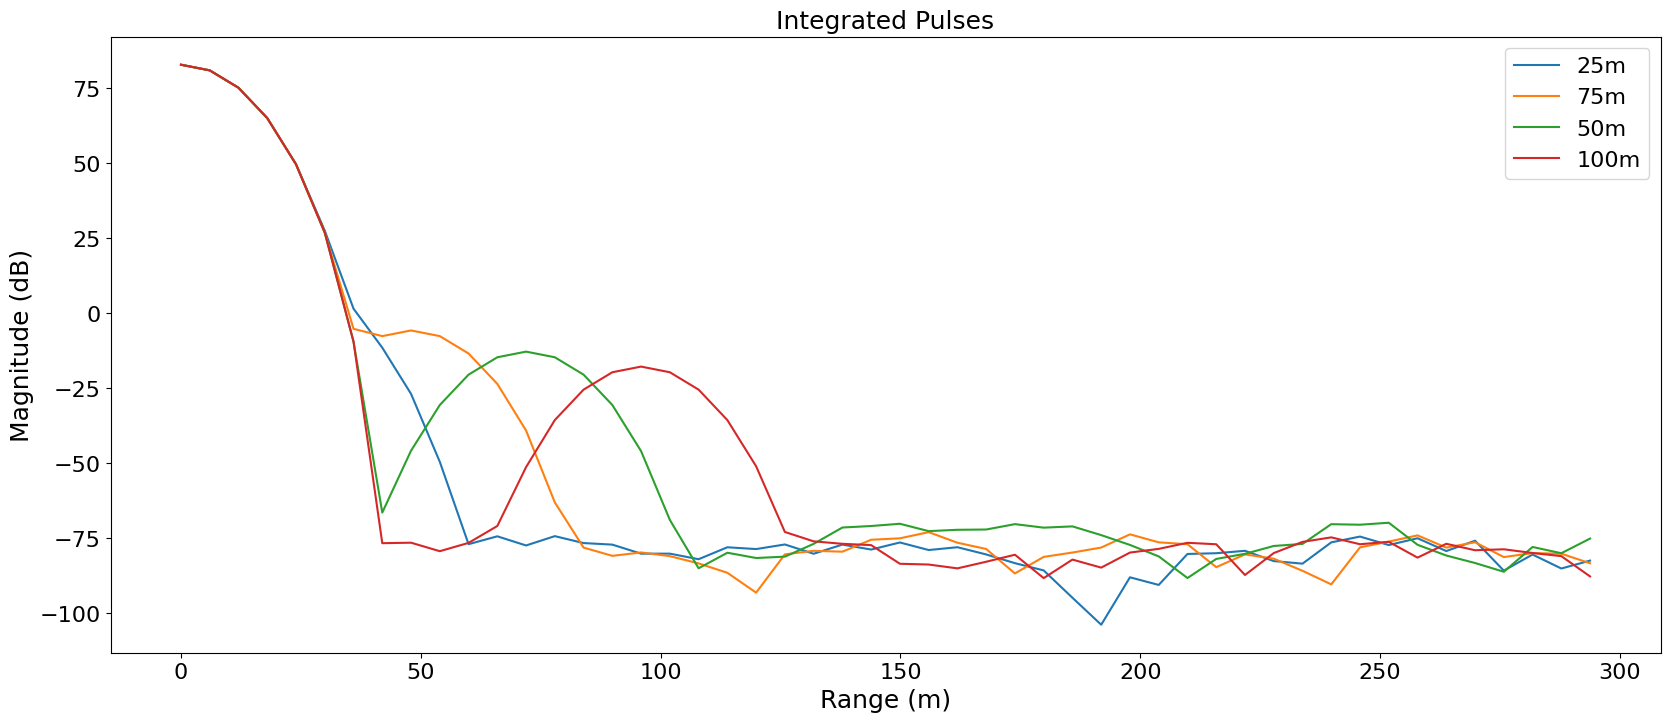

In [29]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
fs = 25e6

Pt_db = 12.5
Pt_lin = 10 ** (Pt_db / 10)
Gr_db = 6
Gt_db = 6
Gr_lin = 10 ** (Gr_db / 10)
Gt_lin = 10 ** (Gt_db / 10)
fc = 2.7e9
lam = c/fc
rcs = 0.89
def get_radar_atten(R):
    Pr_lin = (Pt_lin * Gr_lin * Gt_lin * lam**2 * rcs)/((4*np.pi)**3 * R**4)
    Pr_db = 10*np.log10(Pr_lin)
    #print(f"Pt = {Pt_dbm}dBm")
    print(f"For distance {R}")
    print(f"Pr = {Pr_db+30}dBm")
    atten = np.sqrt(Pr_lin/Pt_lin)
    print(f"atten: {atten}")
    print(f"--------")
    return atten

R = 25
idx_25 = 2*int(R/c * fs)
atten_25 = get_radar_atten(R)
R = 50
idx_50 = 2*int(R/c * fs)
atten_50 = get_radar_atten(R)
R = 75
idx_75 = 2*int(R/c * fs)
atten_75 = get_radar_atten(R)
R = 100
idx_100 = 2*int(R/c * fs)
atten_100 = get_radar_atten(R)

# Generate pulses
num_pulses=100
pulses_arr = []
for i in range(num_pulses):
    random_integer = np.random.randint(0, 10)
    zeros = np.zeros(random_integer).astype(np.complex128)
    pulses_arr.extend(zeros)
    pulses_arr.extend(template_signal)
pulses_arr = np.array(pulses_arr)
pulses_arr_xtalk = 0.1*pulses_arr

pulses_arr_shifted_25 = np.zeros_like(pulses_arr)
pulses_arr_shifted_50 = np.zeros_like(pulses_arr)
pulses_arr_shifted_75 = np.zeros_like(pulses_arr)
pulses_arr_shifted_100 = np.zeros_like(pulses_arr)
pulses_arr_shifted_25[idx_25:] = atten_25*pulses_arr[:-idx_25]
pulses_arr_shifted_50[idx_50:] = atten_50*pulses_arr[:-idx_50]
pulses_arr_shifted_75[idx_75:] = atten_75*pulses_arr[:-idx_75]
pulses_arr_shifted_100[idx_100:] = atten_100*pulses_arr[:-idx_100]
T = 290
B = 24e6
Pn_lin = k*T*B
Pn_db = 10*np.log10(Pn_lin)
print(f"Noise power {Pn_lin} linear, {Pn_db}dB")
R_max = np.power((Pt_lin*Gt_lin*Gr_lin*lam**2 * rcs)/((4*np.pi)**3 * Pn_lin),1/4)
print(f"Theoretical max range {R_max}m")
signal_with_refl_25 = pulses_arr_xtalk + pulses_arr_shifted_25 + np.sqrt(Pn_lin) * (np.random.randn(len(pulses_arr)) + 1j * np.random.randn(len(pulses_arr)))
signal_with_refl_50 = pulses_arr_xtalk + pulses_arr_shifted_50 + np.sqrt(Pn_lin) * (np.random.randn(len(pulses_arr)) + 1j * np.random.randn(len(pulses_arr)))
signal_with_refl_75 = pulses_arr_xtalk + pulses_arr_shifted_75 + np.sqrt(Pn_lin) * (np.random.randn(len(pulses_arr)) + 1j * np.random.randn(len(pulses_arr)))
signal_with_refl_100 = pulses_arr_xtalk + pulses_arr_shifted_100 + np.sqrt(Pn_lin) * (np.random.randn(len(pulses_arr)) + 1j * np.random.randn(len(pulses_arr)))
#signal_with_refl += 0.1 * (np.random.randn(len(LO_arr)) + 1j * np.random.randn(len(LO_arr)))

def cpi(signal, template_signal, ranges, d):
    matched_filter = np.conjugate(template_signal[::-1])
    window = hamming(len(matched_filter))  # Choose the appropriate window function
    window = kaiser(len(matched_filter), 20, sym=True)  # Choose the appropriate window function
    matched_filter = matched_filter * window  # Apply the window
    xcorr_data = fftconvolve(signal, matched_filter, mode='full')
    xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full

    # Extract pulses
    xcorr_matrix = []   
    end = 50
    pulse_sum = np.zeros(end).astype(np.complex128)
    ranges = np.arange(len(template_signal)) * c / (2*25e6)
    ranges = ranges[0:end]
    plt.figure(figsize=(20,8))
    while (len(xcorr_data)>0):
        max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
        xcorr_data_plot = xcorr_data[max_idx:max_idx+pulse_width]
        xcorr_data_plot = xcorr_data_plot[0:end]
        if (len(xcorr_data_plot)==end):
            plt.plot(ranges,20*np.log10(np.abs(xcorr_data_plot)))
            pulse_sum += xcorr_data_plot
            xcorr_data = xcorr_data[pulse_width+pulse_separation:]
            xcorr_matrix.append(xcorr_data_plot)
        else:
            break
    plt.title(f"Overlayed pulses {d}m",fontsize=font1)
    plt.ylabel("Magnitude (dB)",fontsize=font1)
    plt.xlabel("Range (m)",fontsize=font1)
    plt.xticks(fontsize=font2)
    plt.yticks(fontsize=font2)
    plt.show()

    # Range map
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    im_range = axs[0].imshow(20*np.log10(np.abs(xcorr_matrix)), extent=[ranges[0], ranges[-1], 0, len(xcorr_matrix)], aspect='auto', cmap='viridis') 
    axs[0].minorticks_on()
    axs[0].set_ylabel("Pulse number", fontsize=font1)
    axs[0].set_xlabel("Range (m)", fontsize=font1)
    axs[0].set_title("Range Map", fontsize=font1)
    axs[0].tick_params(labelsize=font2)  # Set x and y tick label size

    # Range-doppler
    num_pulses = len(xcorr_matrix)
    doppler_fft = np.fft.fftshift(np.fft.fft(xcorr_matrix, axis=0), axes=0)
    range_doppler_map = 20 * np.log10(np.abs(doppler_fft))

    im_rd = axs[1].imshow(range_doppler_map, extent=[ranges[0], ranges[-1], -num_pulses//2, num_pulses//2],
            aspect='auto', cmap='jet', origin='lower')
    axs[1].set_title('Range-Doppler Map', fontsize=font1)
    axs[1].set_xlabel('Range (m)', fontsize=font1)
    axs[1].set_ylabel('Doppler Bins', fontsize=font1)
    axs[1].tick_params(labelsize=font2)  # Set x and y tick label size


    cbar = plt.colorbar(im_range, ax=axs[0])
    cbar.set_label('Magnitude (dB)', fontsize=font2)  # Set the label for the colorbar
    cbar = plt.colorbar(im_rd, ax=axs[1])
    cbar.set_label('Magnitude (dB)', fontsize=font2)  # Set the label for the colorbar
    plt.tight_layout()
    plt.show()
    return pulse_sum


pulse_sum_25 = cpi(signal_with_refl_25, template_signal, ranges, 25)
pulse_sum_50 = cpi(signal_with_refl_50, template_signal, ranges, 50)
pulse_sum_75 = cpi(signal_with_refl_75, template_signal, ranges, 75)
pulse_sum_100 = cpi(signal_with_refl_100, template_signal, ranges, 100)

plt.figure(figsize=(20,8))
ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:50]
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_25)), label="25m")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_50)), label="75m")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_75)), label="50m")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_100)), label="100m")
plt.legend()
plt.title("Integrated Pulses", fontsize=18)
plt.ylabel("Magnitude (dB)", fontsize=18)
plt.xlabel("Range (m)", fontsize=18)
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.legend(fontsize=font2)
plt.show()




# Reflection Cable

atten: 0.01


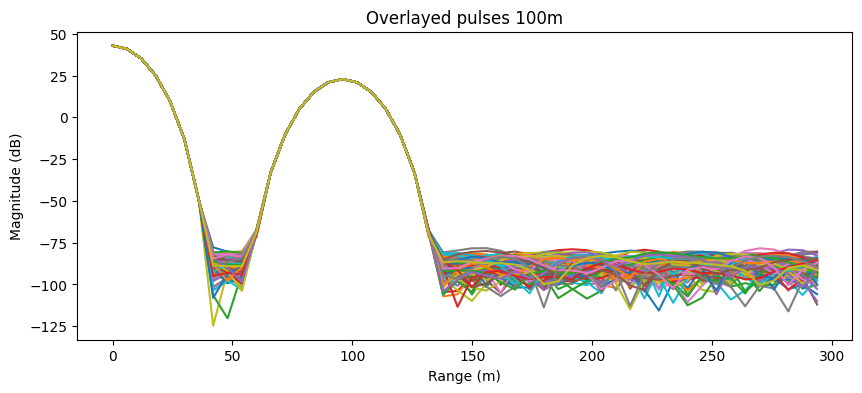

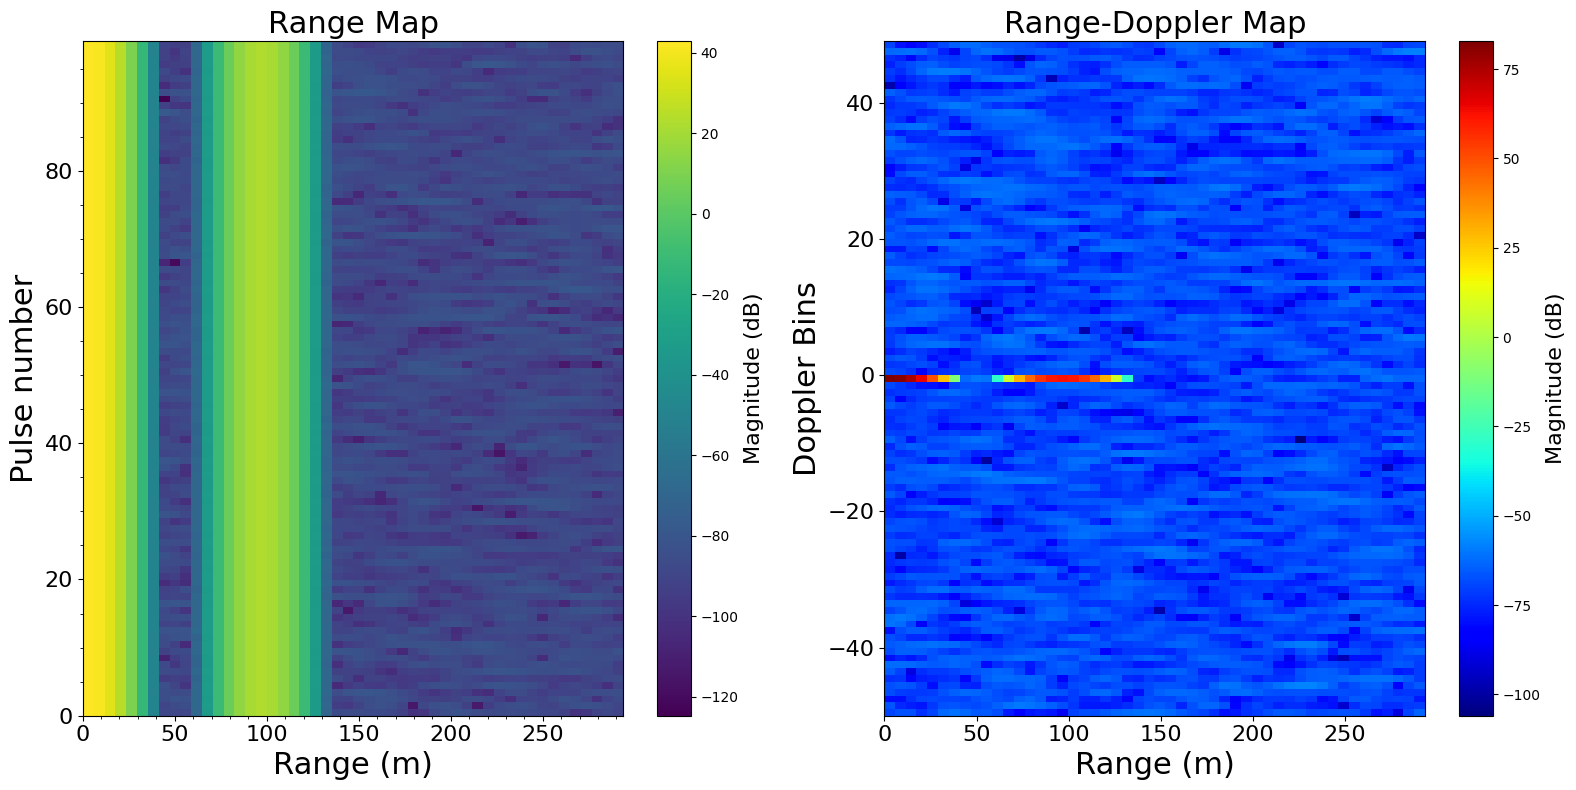

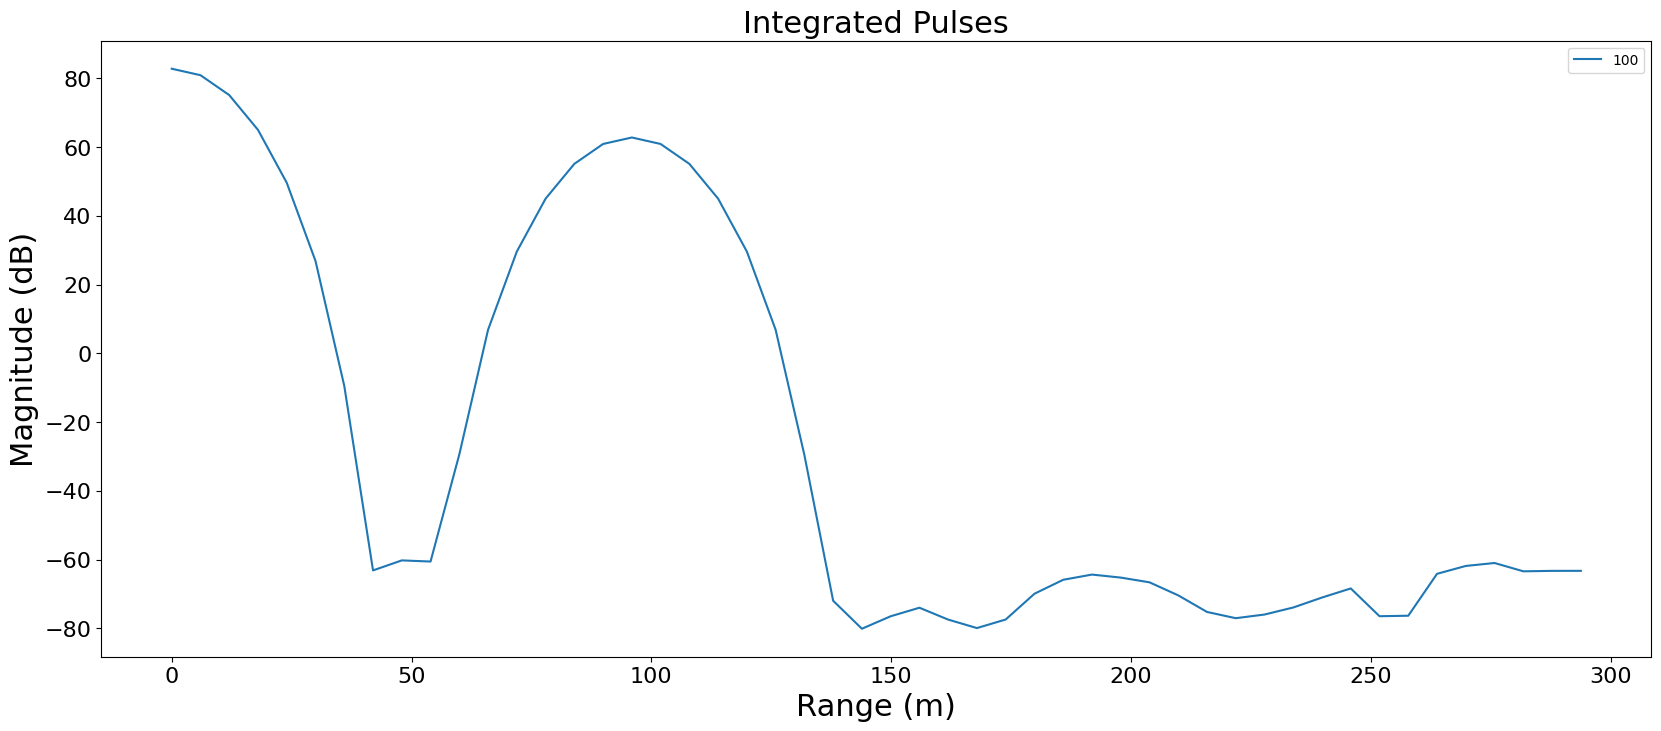

In [24]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
fs = 25e6
R = 125
idx = int(R/c * fs)*2
atten_dbm = 40
atten_db = 20
atten_lin = 10 ** (-atten_db / 10)
atten = atten_lin
print(f"atten: {atten_lin}")


# Generate pulses
num_pulses=100
pulses_arr = []
for i in range(num_pulses):
    random_integer = np.random.randint(0, 10)
    zeros = np.zeros(random_integer).astype(np.complex128)
    pulses_arr.extend(zeros)
    pulses_arr.extend(template_signal)
pulses_arr = np.array(pulses_arr)
pulses_arr_xtalk = 0.1*pulses_arr

pulses_arr_shifted = np.zeros_like(pulses_arr)
pulses_arr_shifted[idx:] = atten*pulses_arr[:-idx]

noise = 1e-6 * (np.random.randn(len(pulses_arr)) + 1j * np.random.randn(len(pulses_arr)))
signal_with_refl = pulses_arr_xtalk + pulses_arr_shifted + noise

end = 50
def cpi(signal, template_signal, d):
    matched_filter = np.conjugate(template_signal[::-1])
    window = hamming(len(matched_filter))  # Choose the appropriate window function
    window = kaiser(len(matched_filter), 20, sym=True)  # Choose the appropriate window function
    matched_filter = matched_filter * window  # Apply the window
    xcorr_data = fftconvolve(signal, matched_filter, mode='full')
    xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full

    # Extract pulses
    xcorr_matrix = []   
    pulse_sum = np.zeros(end).astype(np.complex128)
    ranges = np.arange(len(template_signal)) * c / (2*25e6)
    ranges = ranges[0:end]
    plt.figure(figsize=(10,4))
    while (len(xcorr_data)>0):
        max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
        xcorr_data_plot = xcorr_data[max_idx:max_idx+pulse_width]
        xcorr_data_plot = xcorr_data_plot[0:end]
        if (len(xcorr_data_plot)==end):
            plt.plot(ranges,20*np.log10(np.abs(xcorr_data_plot)))
            pulse_sum += xcorr_data_plot
            xcorr_data = xcorr_data[pulse_width+pulse_separation:]
            xcorr_matrix.append(xcorr_data_plot)
        else:
            break
    plt.title(f"Overlayed pulses {d}m")
    plt.ylabel("Magnitude (dB)")
    plt.xlabel("Range (m)")
    plt.show()

    # Range map
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    im_range = axs[0].imshow(20*np.log10(np.abs(xcorr_matrix)), extent=[ranges[0], ranges[-1], 0, len(xcorr_matrix)], aspect='auto', cmap='viridis') 
    axs[0].minorticks_on()
    axs[0].set_ylabel("Pulse number", fontsize=font1)
    axs[0].set_xlabel("Range (m)", fontsize=font1)
    axs[0].set_title("Range Map", fontsize=font1)
    axs[0].tick_params(labelsize=font2)  # Set x and y tick label size

    # Range-doppler
    num_pulses = len(xcorr_matrix)
    doppler_fft = np.fft.fftshift(np.fft.fft(xcorr_matrix, axis=0), axes=0)
    range_doppler_map = 20 * np.log10(np.abs(doppler_fft))

    im_rd = axs[1].imshow(range_doppler_map, extent=[ranges[0], ranges[-1], -num_pulses//2, num_pulses//2],
            aspect='auto', cmap='jet', origin='lower')
    axs[1].set_title('Range-Doppler Map', fontsize=font1)
    axs[1].set_xlabel('Range (m)', fontsize=font1)
    axs[1].set_ylabel('Doppler Bins', fontsize=font1)
    axs[1].tick_params(labelsize=font2)  # Set x and y tick label size


    cbar = plt.colorbar(im_range, ax=axs[0])
    cbar.set_label('Magnitude (dB)', fontsize=font2)  # Set the label for the colorbar
    cbar = plt.colorbar(im_rd, ax=axs[1])
    cbar.set_label('Magnitude (dB)', fontsize=font2)  # Set the label for the colorbar
    plt.tight_layout()
    plt.show()
    return pulse_sum


pulse_sum = cpi(signal_with_refl, template_signal, R)
ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:end]
plt.figure(figsize=(20,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum)), label=f"{R}")
plt.legend()
plt.title("Integrated Pulses", fontsize=font1)
plt.ylabel("Magnitude (dB)", fontsize=font1)
plt.xlabel("Range (m)", fontsize=font1)
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.show()

# Max Range

For distance 1000
Pr = -118.07325707883496dBm
atten: 9.361321185122277e-09
--------
Noise power 9.60931704e-14 linear, -130.17307477711205dB
Theoretical max range 356.858004349278m


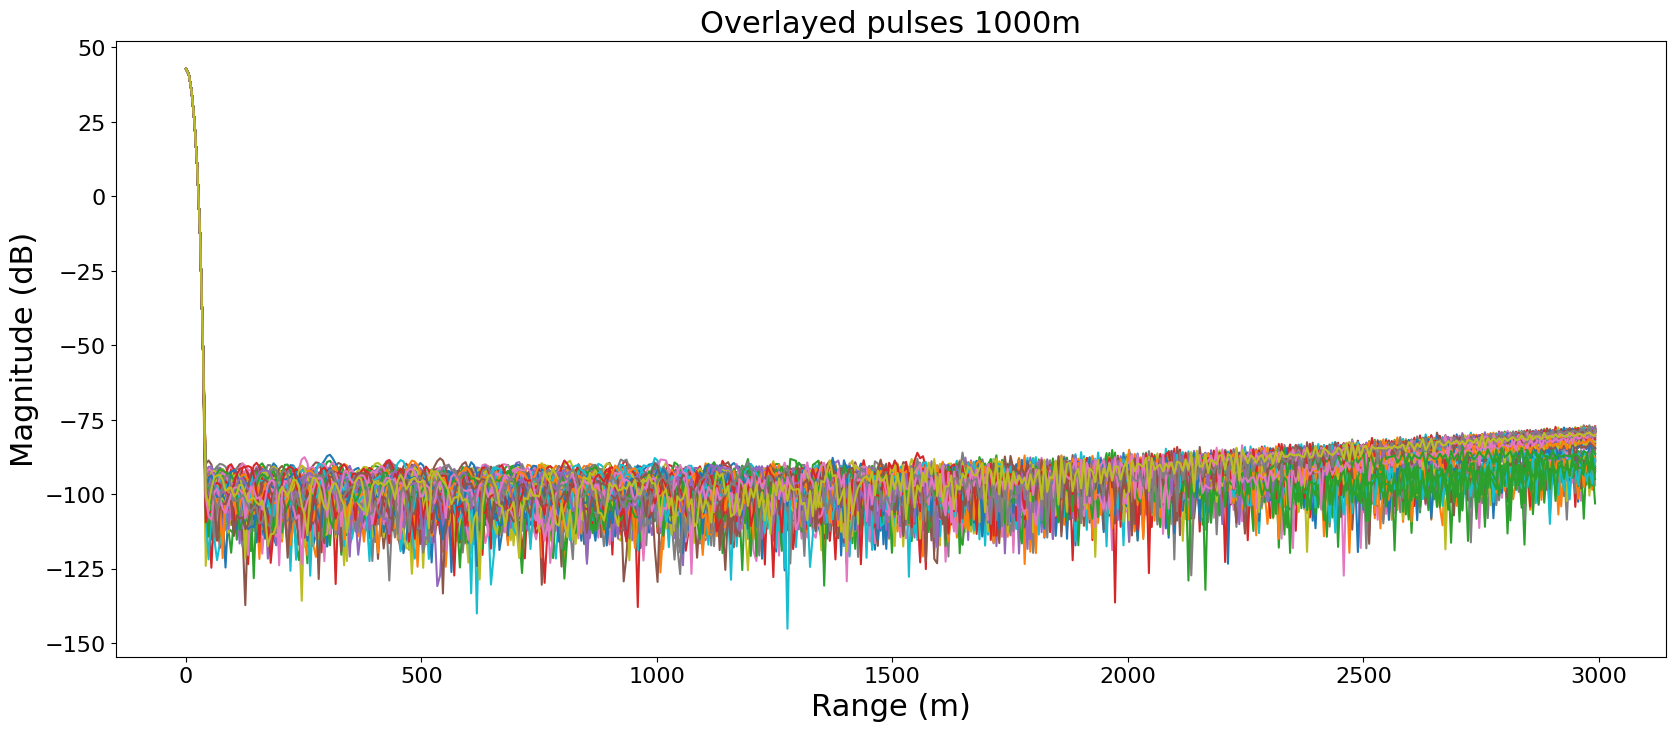

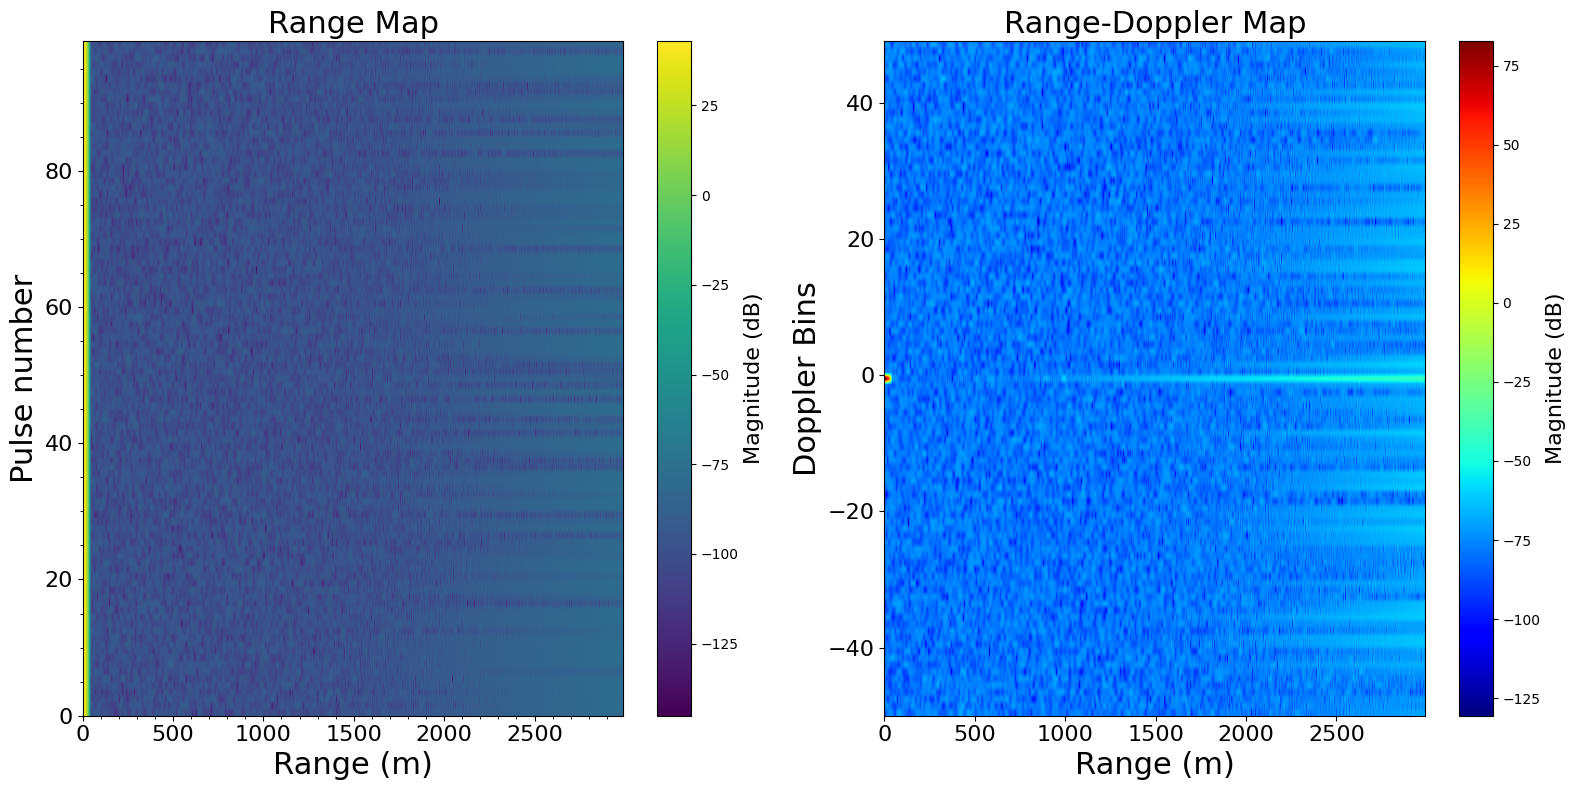

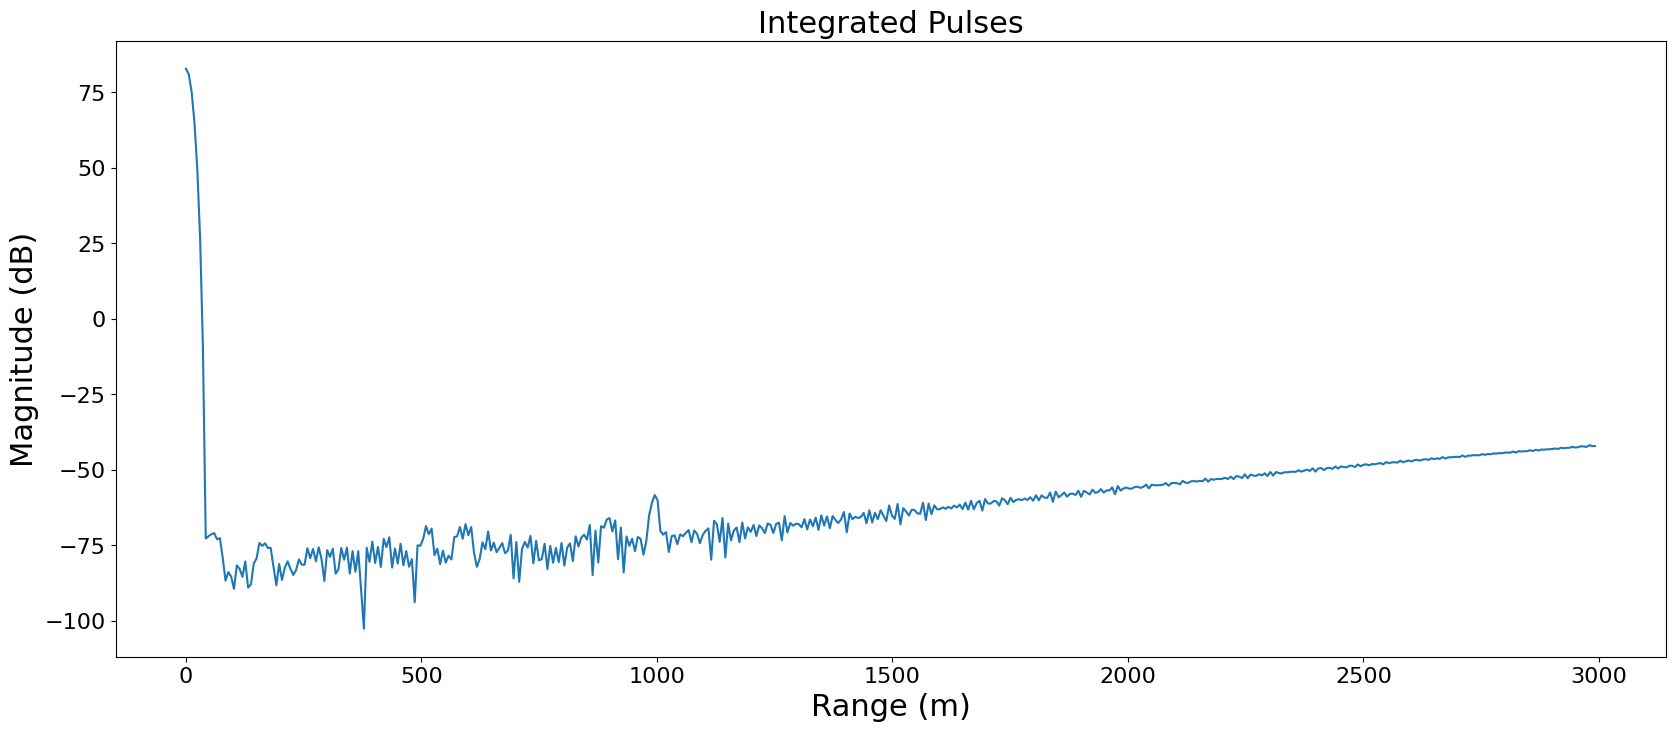

In [33]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
fs = 25e6

Pt_db = 12.5
Pt_lin = 10 ** (Pt_db / 10) 
Gr_db = 6
Gt_db = 6
Gr_lin = 10 ** (Gr_db / 10)
Gt_lin = 10 ** (Gt_db / 10)
fc = 2.7e9
lam = c/fc
rcs = 0.89
def get_radar_atten(R):
    Pr_lin = (Pt_lin * Gr_lin * Gt_lin * lam**2 * rcs)/((4*np.pi)**3 * R**4)
    Pr_db = 10*np.log10(Pr_lin)
    #print(f"Pt = {Pt_dbm}dBm")
    print(f"For distance {R}")
    print(f"Pr = {Pr_db+30}dBm")
    atten = np.sqrt(Pr_lin/Pt_lin)
    print(f"atten: {atten}")
    print(f"--------")
    return atten

R = 1000
idx = 2*int(R/c * fs)
atten = get_radar_atten(R)


# Generate pulses
num_pulses=100
pulses_arr = []
for i in range(num_pulses):
    random_integer = np.random.randint(0, 10)
    zeros = np.zeros(random_integer).astype(np.complex128)
    pulses_arr.extend(zeros)
    pulses_arr.extend(template_signal)
pulses_arr = np.array(pulses_arr)
pulses_arr_xtalk = 0.1*pulses_arr

pulses_arr_shifted = np.zeros_like(pulses_arr)
pulses_arr_shifted[idx:] = atten*pulses_arr[:-idx]

T = 290
B = 24e6
Pn_lin = k*T*B
Pn_db = 10*np.log10(Pn_lin)
print(f"Noise power {Pn_lin} linear, {Pn_db}dB")
R_max = np.power((Pt_lin*Gt_lin*Gr_lin*lam**2 * rcs)/((4*np.pi)**3 * Pn_lin),1/4)
print(f"Theoretical max range {R_max}m")
signal_with_refl = pulses_arr_xtalk + pulses_arr_shifted + np.sqrt(Pn_lin) * (np.random.randn(len(pulses_arr)) + 1j * np.random.randn(len(pulses_arr)))

end = 500
def cpi(signal, template_signal, d):
    matched_filter = np.conjugate(template_signal[::-1])
    window = hamming(len(matched_filter))  # Choose the appropriate window function
    window = kaiser(len(matched_filter), 20, sym=True)  # Choose the appropriate window function
    matched_filter = matched_filter * window  # Apply the window
    xcorr_data = fftconvolve(signal, matched_filter, mode='full')
    xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full

    # Extract pulses
    xcorr_matrix = []   
    pulse_sum = np.zeros(end).astype(np.complex128)
    ranges = np.arange(len(template_signal)) * c / (2*25e6)
    ranges = ranges[0:end]
    plt.figure(figsize=(20,8))
    while (len(xcorr_data)>0):
        max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
        xcorr_data_plot = xcorr_data[max_idx:max_idx+pulse_width]
        xcorr_data_plot = xcorr_data_plot[0:end]
        if (len(xcorr_data_plot)==end):
            plt.plot(ranges,20*np.log10(np.abs(xcorr_data_plot)))
            pulse_sum += xcorr_data_plot
            xcorr_data = xcorr_data[pulse_width+pulse_separation:]
            xcorr_matrix.append(xcorr_data_plot)
        else:
            break
    plt.title(f"Overlayed pulses {d}m", fontsize=font1)
    plt.ylabel("Magnitude (dB)", fontsize=font1)
    plt.xlabel("Range (m)", fontsize=font1)
    plt.xticks(fontsize=font2)
    plt.yticks(fontsize=font2)  
    plt.show()

    # Range map
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    im_range = axs[0].imshow(20*np.log10(np.abs(xcorr_matrix)), extent=[ranges[0], ranges[-1], 0, len(xcorr_matrix)], aspect='auto', cmap='viridis') 
    axs[0].minorticks_on()
    axs[0].set_ylabel("Pulse number", fontsize=font1)
    axs[0].set_xlabel("Range (m)", fontsize=font1)
    axs[0].set_title("Range Map", fontsize=font1)
    axs[0].tick_params(labelsize=font2)  # Set x and y tick label size

    # Range-doppler
    num_pulses = len(xcorr_matrix)
    doppler_fft = np.fft.fftshift(np.fft.fft(xcorr_matrix, axis=0), axes=0)
    range_doppler_map = 20 * np.log10(np.abs(doppler_fft))

    im_rd = axs[1].imshow(range_doppler_map, extent=[ranges[0], ranges[-1], -num_pulses//2, num_pulses//2],
            aspect='auto', cmap='jet', origin='lower')
    axs[1].set_title('Range-Doppler Map', fontsize=font1)
    axs[1].set_xlabel('Range (m)', fontsize=font1)
    axs[1].set_ylabel('Doppler Bins', fontsize=font1)
    axs[1].tick_params(labelsize=font2)  # Set x and y tick label size


    cbar = plt.colorbar(im_range, ax=axs[0])
    cbar.set_label('Magnitude (dB)', fontsize=font2)  # Set the label for the colorbar
    cbar = plt.colorbar(im_rd, ax=axs[1])
    cbar.set_label('Magnitude (dB)', fontsize=font2)  # Set the label for the colorbar
    plt.tight_layout()
    plt.show()
    return pulse_sum


pulse_sum = cpi(signal_with_refl, template_signal, R)
ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:end]
plt.figure(figsize=(20,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum)), label=f"{R}")
plt.title("Integrated Pulses", fontsize=font1)
plt.ylabel("Magnitude (dB)", fontsize=font1)
plt.xlabel("Range (m)", fontsize=font1)
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)  
plt.show()




# Velocity

For distance 100
Pr = -78.07325707883496dBm
atten: 9.361321185122276e-07
--------
Noise power 9.60931704e-14 linear, -130.17307477711205dB
Theoretical max range 356.858004349278m


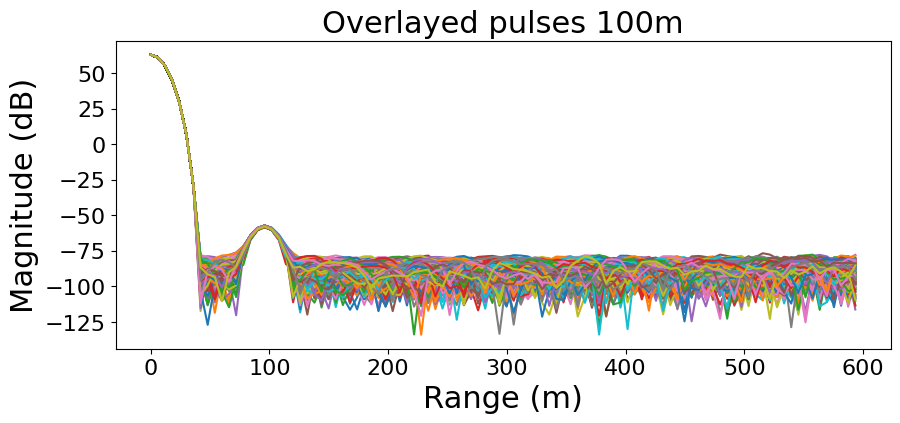

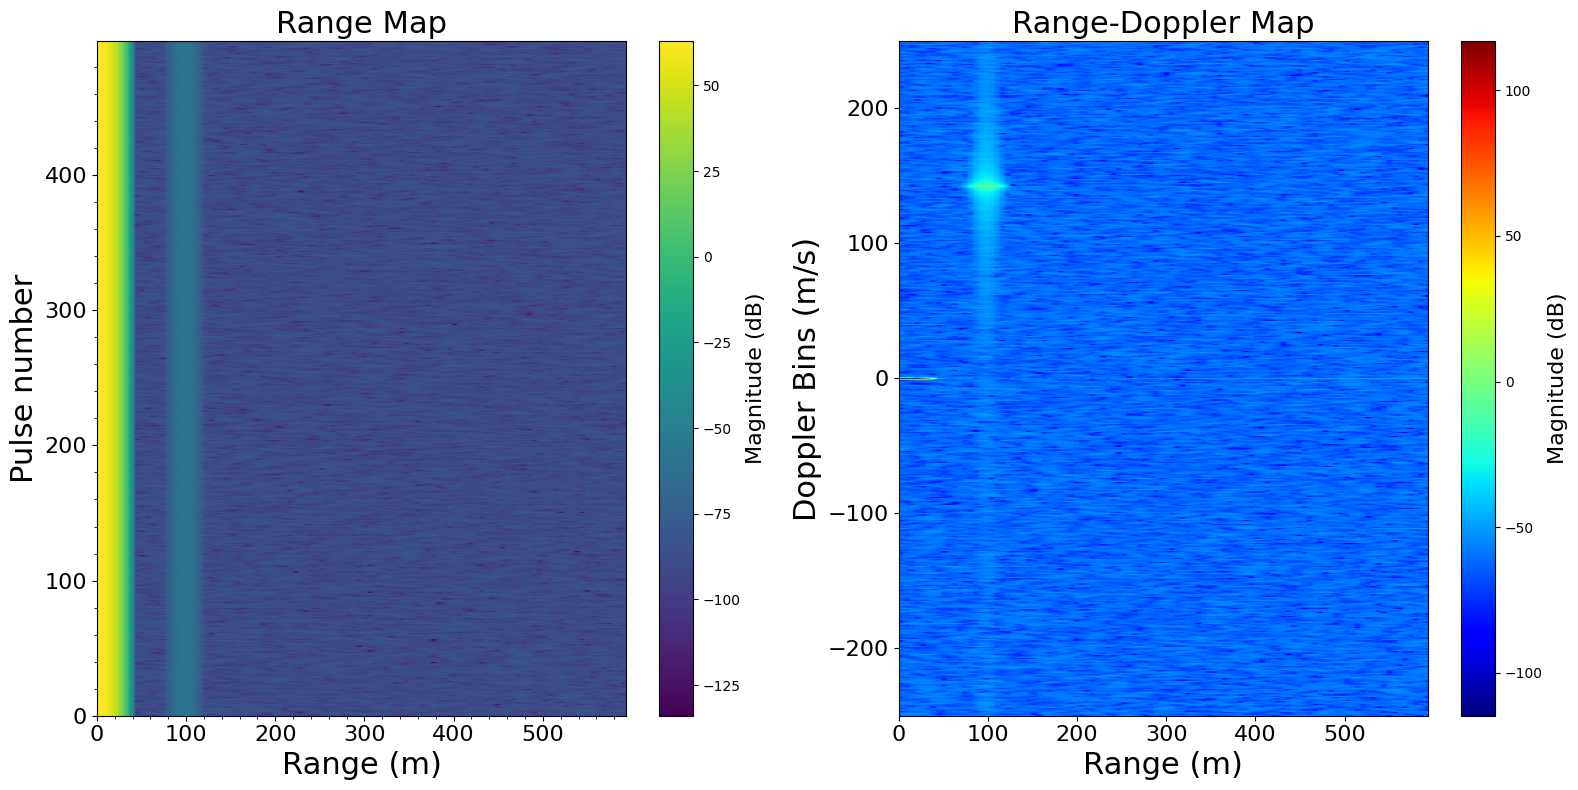

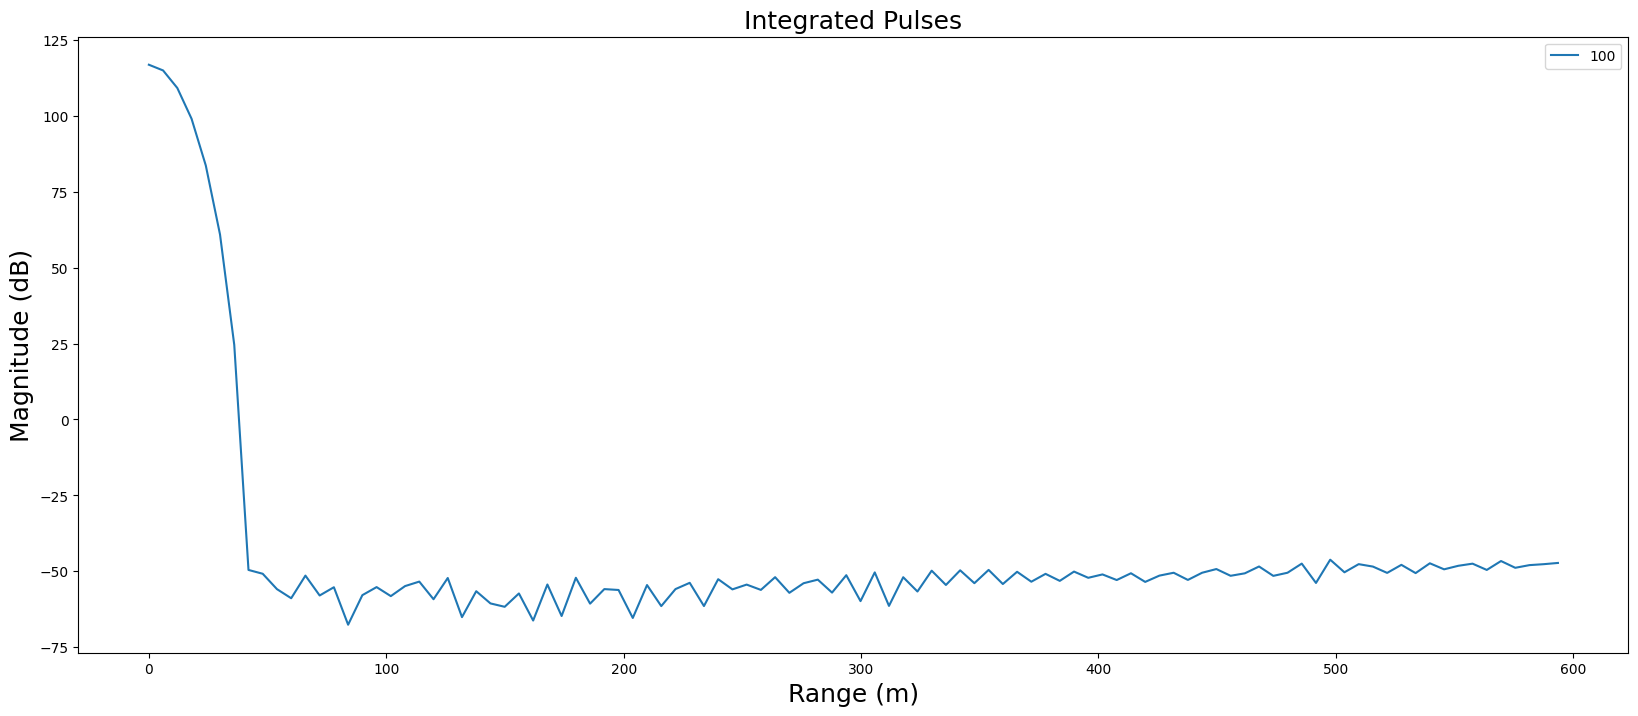

In [41]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
phi = np.pi / 3   # Phase shift in radians (45 degrees)
Y = np.fft.fft(template_signal)
n = len(Y)
phase_shift = np.exp(1j * phi)  # Phase shift as a complex number
Y_shifted = Y * phase_shift
template_signal_shifted = np.fft.ifft(Y_shifted)

fs = 25e6

Pt_db = 12.5
Pt_lin = 10 ** (Pt_db / 10) 
Gr_db = 6
Gt_db = 6
Gr_lin = 10 ** (Gr_db / 10)
Gt_lin = 10 ** (Gt_db / 10)
fc = 2.7e9
lam = c/fc
rcs = 0.89
velocity = 50
delta_phase = (4*np.pi*velocity*pulse_width)/lam
def get_radar_atten(R):
    Pr_lin = (Pt_lin * Gr_lin * Gt_lin * lam**2 * rcs)/((4*np.pi)**3 * R**4)
    Pr_db = 10*np.log10(Pr_lin)
    #print(f"Pt = {Pt_dbm}dBm")
    print(f"For distance {R}")
    print(f"Pr = {Pr_db+30}dBm")
    atten = np.sqrt(Pr_lin/Pt_lin)
    print(f"atten: {atten}")
    print(f"--------")
    return atten

R = 100
idx = 2*int(R/c * fs)
atten = get_radar_atten(R)


# Generate pulses
num_pulses=500 # INCREASE PRF FOR VELOCITY RESOLUTION
pulses_arr = []
v = 0
phase_shift = 0
for i in range(num_pulses):
    random_integer = np.random.randint(0, 10)
    zeros = np.zeros(random_integer).astype(np.complex128)
    pulses_arr.extend(zeros)
    pulses_arr.extend(template_signal)
    pulses_arr[-pulse_width+idx+int(v):] += atten*template_signal_shifted[:-(idx+int(v))]*np.exp(1j*phase_shift)
    #v = v+0.1
    phase_shift = phase_shift+delta_phase
pulses_arr = np.array(pulses_arr)
pulses_arr_xtalk = 0.1*pulses_arr

T = 290
B = 24e6
Pn_lin = k*T*B
Pn_db = 10*np.log10(Pn_lin)
print(f"Noise power {Pn_lin} linear, {Pn_db}dB")
R_max = np.power((Pt_lin*Gt_lin*Gr_lin*lam**2 * rcs)/((4*np.pi)**3 * Pn_lin),1/4)
print(f"Theoretical max range {R_max}m")
signal_with_refl = pulses_arr + 1e-6 * (np.random.randn(len(pulses_arr)) + 1j * np.random.randn(len(pulses_arr)))

end = 100
def cpi(signal, template_signal, d):
    matched_filter = np.conjugate(template_signal[::-1])
    window = hamming(len(matched_filter))  # Choose the appropriate window function
    window = kaiser(len(matched_filter), 20, sym=True)  # Choose the appropriate window function
    matched_filter = matched_filter * window  # Apply the window
    xcorr_data = fftconvolve(signal, matched_filter, mode='full')
    xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full

    # Extract pulses
    xcorr_matrix = []   
    pulse_sum = np.zeros(end).astype(np.complex128)
    ranges = np.arange(len(template_signal)) * c / (2*25e6)
    ranges = ranges[0:end]
    plt.figure(figsize=(10,4))
    while (len(xcorr_data)>0):
        max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
        xcorr_data_plot = xcorr_data[max_idx:max_idx+pulse_width]
        xcorr_data_plot = xcorr_data_plot[0:end]
        if (len(xcorr_data_plot)==end):
            plt.plot(ranges,20*np.log10(np.abs(xcorr_data_plot)))
            pulse_sum += xcorr_data_plot
            xcorr_data = xcorr_data[pulse_width+pulse_separation:]
            xcorr_matrix.append(xcorr_data_plot)
        else:
            break
    plt.title(f"Overlayed pulses {d}m", fontsize=font1)
    plt.ylabel("Magnitude (dB)", fontsize=font1)
    plt.xlabel("Range (m)", fontsize=font1)
    plt.xticks(fontsize=font2)
    plt.yticks(fontsize=font2)  
    plt.show()

    # Range map
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    im_range = axs[0].imshow(20*np.log10(np.abs(xcorr_matrix)), extent=[ranges[0], ranges[-1], 0, len(xcorr_matrix)], aspect='auto', cmap='viridis') 
    axs[0].minorticks_on()
    axs[0].set_ylabel("Pulse number", fontsize=font1)
    axs[0].set_xlabel("Range (m)", fontsize=font1)
    axs[0].set_title("Range Map", fontsize=font1)
    axs[0].tick_params(labelsize=font2)  # Set x and y tick label size

    # Range-doppler
    num_pulses = len(xcorr_matrix)
    doppler_fft = np.fft.fftshift(np.fft.fft(xcorr_matrix, axis=0), axes=0)
    range_doppler_map = 20 * np.log10(np.abs(doppler_fft))

    im_rd = axs[1].imshow(range_doppler_map, extent=[ranges[0], ranges[-1], -num_pulses//2, num_pulses//2],
            aspect='auto', cmap='jet', origin='lower')
    axs[1].set_title('Range-Doppler Map', fontsize=font1)
    axs[1].set_xlabel('Range (m)', fontsize=font1)
    axs[1].set_ylabel('Doppler Bins (m/s)', fontsize=font1)
    axs[1].tick_params(labelsize=font2)  # Set x and y tick label size


    cbar = plt.colorbar(im_range, ax=axs[0])
    cbar.set_label('Magnitude (dB)', fontsize=font2)  # Set the label for the colorbar
    cbar = plt.colorbar(im_rd, ax=axs[1])
    cbar.set_label('Magnitude (dB)', fontsize=font2)  # Set the label for the colorbar
    plt.tight_layout()
    plt.show()
    return pulse_sum


pulse_sum = cpi(signal_with_refl, template_signal, R)
ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:end]
plt.figure(figsize=(20,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum)), label=f"{R}")
plt.legend()
plt.title("Integrated Pulses", fontsize=18)
plt.ylabel("Magnitude (dB)", fontsize=18)
plt.xlabel("Range (m)", fontsize=18)
plt.show()

# Different windows

For distance 200
Pr = -90.11445690539419dBm
atten: 2.340330296280569e-07
--------
Noise power 9.60931704e-14 linear, -130.17307477711205dB
Theoretical max range 356.858004349278m


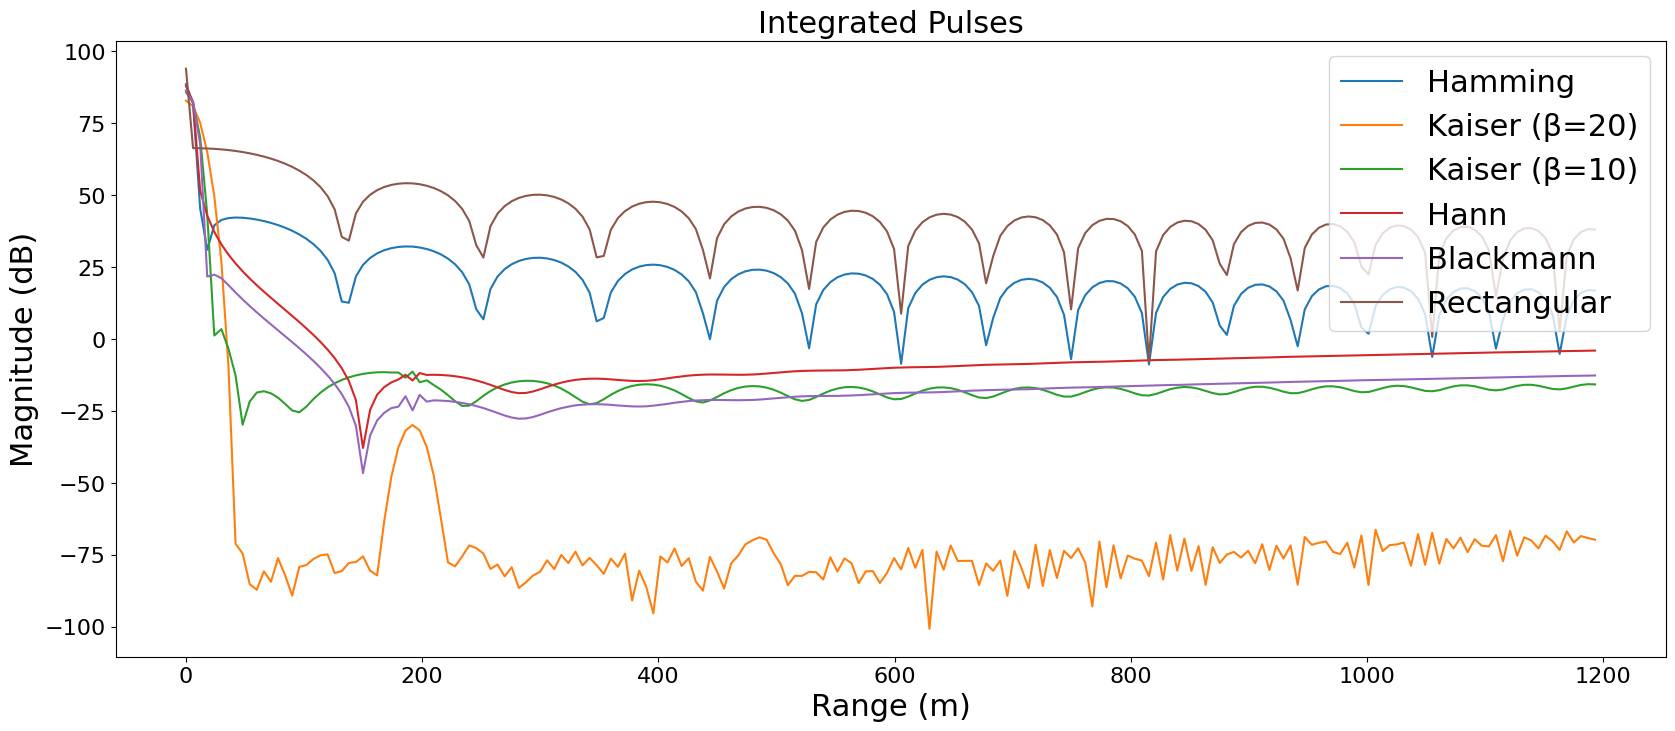

In [31]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
fs = 25e6

Pt_db = 12.5
Pt_lin = 10 ** (Pt_db / 10) 
Gr_db = 6
Gt_db = 6
Gr_lin = 10 ** (Gr_db / 10)
Gt_lin = 10 ** (Gt_db / 10)
fc = 2.7e9
lam = c/fc
rcs = 0.89
def get_radar_atten(R):
    Pr_lin = (Pt_lin * Gr_lin * Gt_lin * lam**2 * rcs)/((4*np.pi)**3 * R**4)
    Pr_db = 10*np.log10(Pr_lin)
    #print(f"Pt = {Pt_dbm}dBm")
    print(f"For distance {R}")
    print(f"Pr = {Pr_db+30}dBm")
    atten = np.sqrt(Pr_lin/Pt_lin)
    print(f"atten: {atten}")
    print(f"--------")
    return atten

R = 200
idx = 2*int(R/c * fs)
atten = get_radar_atten(R)


# Generate pulses
num_pulses=100
pulses_arr = []
for i in range(num_pulses):
    random_integer = np.random.randint(0, 10)
    zeros = np.zeros(random_integer).astype(np.complex128)
    pulses_arr.extend(zeros)
    pulses_arr.extend(template_signal)
pulses_arr = np.array(pulses_arr)
pulses_arr_xtalk = 0.1*pulses_arr

pulses_arr_shifted = np.zeros_like(pulses_arr)
pulses_arr_shifted[idx:] = atten*pulses_arr[:-idx]

T = 290
B = 24e6
Pn_lin = k*T*B
Pn_db = 10*np.log10(Pn_lin)
print(f"Noise power {Pn_lin} linear, {Pn_db}dB")
R_max = np.power((Pt_lin*Gt_lin*Gr_lin*lam**2 * rcs)/((4*np.pi)**3 * Pn_lin),1/4)
print(f"Theoretical max range {R_max}m")
signal_with_refl = pulses_arr_xtalk + pulses_arr_shifted + np.sqrt(Pn_lin) * (np.random.randn(len(pulses_arr)) + 1j * np.random.randn(len(pulses_arr)))

end = 200
def cpi_windowing(signal, matched_filter, window_type):
    xcorr_data = fftconvolve(signal, matched_filter, mode='full')
    xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full

    # Extract pulses 
    pulse_sum = np.zeros(end).astype(np.complex128)
    while (len(xcorr_data)>0):
        max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
        xcorr_data_plot = xcorr_data[max_idx:max_idx+pulse_width]
        xcorr_data_plot = xcorr_data_plot[0:end]
        if (len(xcorr_data_plot)==end):
            pulse_sum += xcorr_data_plot
            xcorr_data = xcorr_data[pulse_width+pulse_separation:]
        else:
            break
    return pulse_sum

matched_filter = np.conjugate(template_signal[::-1])

window = hamming(len(matched_filter))  # Choose the appropriate window function
matched_filter_windowed = matched_filter * window  # Apply the window
pulse_sum1 = cpi_windowing(signal_with_refl, matched_filter_windowed, "Hamming")

window = kaiser(len(matched_filter), 20, sym=True) 
matched_filter_windowed = matched_filter * window 
pulse_sum2 = cpi_windowing(signal_with_refl, matched_filter_windowed, "Kaiser (β=20)")

window = kaiser(len(matched_filter), 10, sym=True) 
matched_filter_windowed = matched_filter * window 
pulse_sum3 = cpi_windowing(signal_with_refl, matched_filter_windowed, "Kaiser (β=10)")

window = hann(len(matched_filter), sym=True) 
matched_filter_windowed = matched_filter * window 
pulse_sum4 = cpi_windowing(signal_with_refl, matched_filter_windowed, "Hann")

window = blackman(len(matched_filter), sym=True) 
matched_filter_windowed = matched_filter * window 
pulse_sum5 = cpi_windowing(signal_with_refl, matched_filter_windowed, "Blackman")

pulse_sum6 = cpi_windowing(signal_with_refl, matched_filter, "Rectangular")

ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:end]
plt.figure(figsize=(20,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum1)), label=f"Hamming")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum2)), label=f"Kaiser (β=20)")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum3)), label=f"Kaiser (β=10)")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum4)), label=f"Hann")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum5)), label=f"Blackmann")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum6)), label=f"Rectangular")
plt.legend(fontsize=font1)
plt.title("Integrated Pulses", fontsize=font1)
plt.ylabel("Magnitude (dB)", fontsize=font1)
plt.xlabel("Range (m)", fontsize=font1)
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)  
plt.show()

# Multiple Targets

atten: 0.001


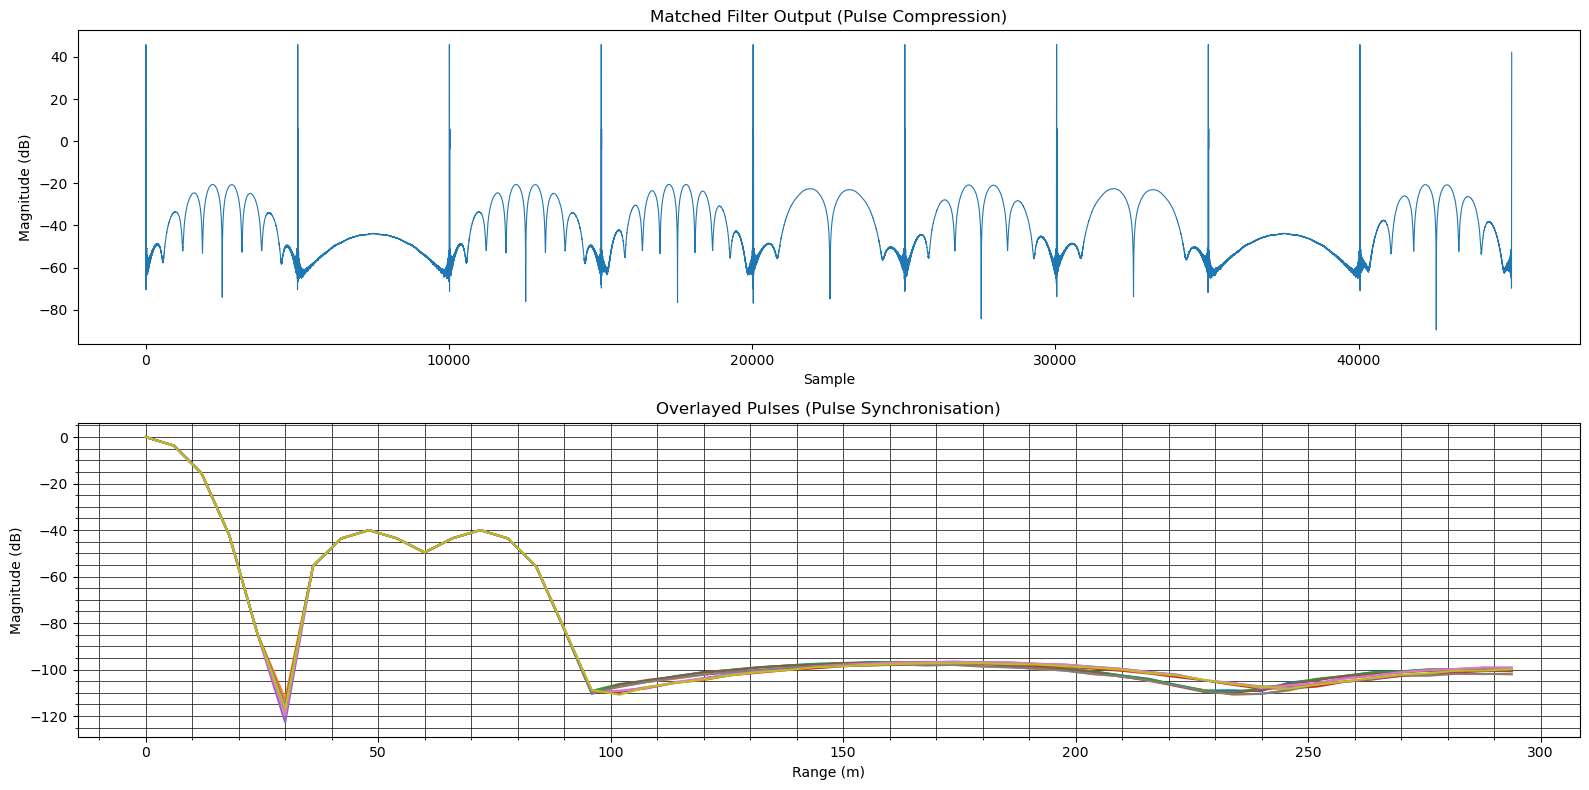

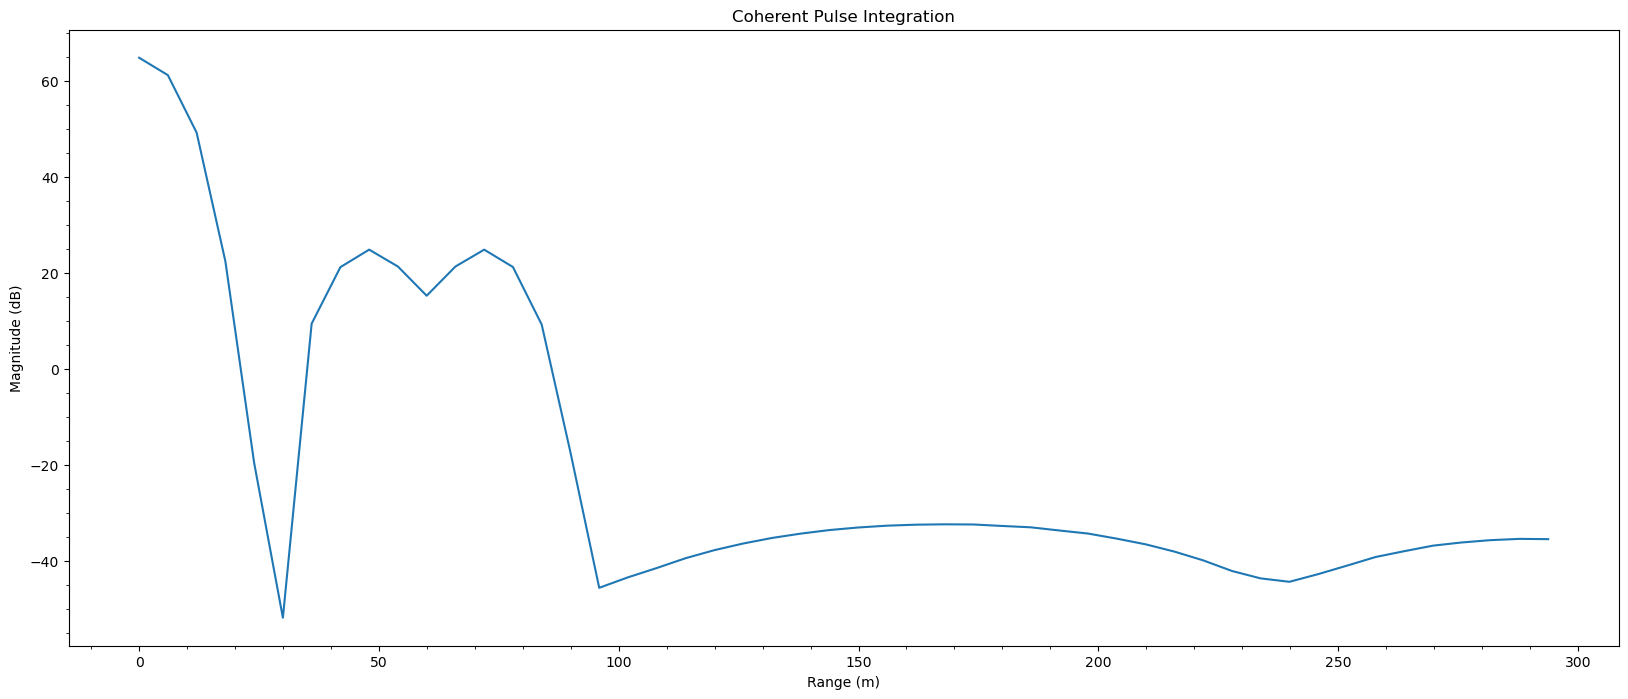

In [18]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
fs = 25e6
d = 50
d1 = 75
idx = int(d/c * fs)*2
idx1 = int(d1/c * fs)*2
atten_dbm = 40
atten_db = 30
atten_lin = 10 ** (-atten_db / 10)
print(f"atten: {atten_lin}")

# Generate pulses
num_pulses=10
pulses_arr = []
for i in range(num_pulses):
    random_integer = np.random.randint(0, 10)
    zeros = np.zeros(random_integer).astype(np.complex128)
    pulses_arr.extend(zeros)
    pulses_arr.extend(template_signal)
pulses_arr = np.array(pulses_arr)
pulses_arr_xtalk = 0.1*pulses_arr


pulses_arr_shifted = np.zeros_like(pulses_arr)
pulses_arr_shifted[idx:] = atten_lin*pulses_arr[:-idx]
pulses_arr_shifted1 = np.zeros_like(pulses_arr)
pulses_arr_shifted1[idx1:] = atten_lin*pulses_arr[:-idx1]
signal_with_refl = pulses_arr_xtalk + pulses_arr_shifted + pulses_arr_shifted1
signal_with_refl += 1e-6 * (np.random.randn(len(signal_with_refl)) + 1j * np.random.randn(len(signal_with_refl)))

matched_filter = np.conjugate(template_signal[::-1])
window = hamming(len(matched_filter))  # Choose the appropriate window function
window = kaiser(len(matched_filter), 10, sym=True)  # Choose the appropriate window function
matched_filter = matched_filter * window  # Apply the window
xcorr_data = fftconvolve(signal_with_refl, matched_filter, mode='full')
xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full

fig, axs = plt.subplots(2, 1, figsize=(16, 8))
axs[0].plot(20*np.log10(np.abs(xcorr_data)),linewidth=0.8)
axs[0].set_title("Matched Filter Output (Pulse Compression)")
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Magnitude (dB)")

# Extract pulses
xcorr_matrix = []
ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:50]
pulse_sum = np.zeros(50).astype(np.complex128)
while (len(xcorr_data)>0):
    max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
    xcorr_data_plot = xcorr_data[max_idx:max_idx+pulse_width]
    xcorr_data_plot = xcorr_data_plot[0:50]
    if (len(xcorr_data_plot)==50):
        axs[1].plot(ranges,20*np.log10(np.abs(xcorr_data_plot/np.max(xcorr_data_plot))))
        pulse_sum += xcorr_data_plot
        xcorr_data = xcorr_data[pulse_width+pulse_separation:]
        xcorr_matrix.append(xcorr_data_plot)
    else:
        break

#axs[2].set_xticks(ranges)
axs[1].grid(True, which='both')
axs[1].grid(which='minor', linewidth=0.5, color='black')
axs[1].grid(which='major', linewidth=0.5, color='black')
axs[1].minorticks_on()
#plt.setp(axs[2].get_xticklabels(), fontsize=4)
axs[1].set_title("Overlayed Pulses (Pulse Synchronisation)")
axs[1].set_xlabel("Range (m)")
axs[1].set_ylabel("Magnitude (dB)")

plt.tight_layout()
plt.show()

plt.figure(figsize=(20,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum)))
plt.minorticks_on()
plt.title("Coherent Pulse Integration")
plt.xlabel("Range (m)")
plt.ylabel("Magnitude (dB)")
plt.show()


# FMCW

Expected beat f 3602.4922281400422Hz
For distance 200
Pr = -85.13677665842113dBm
atten: 4.1510806103504373e-07
--------
Noise power 9.60931704e-14 linear, -130.17307477711205dB
Theoretical max range 475.2667684119655m


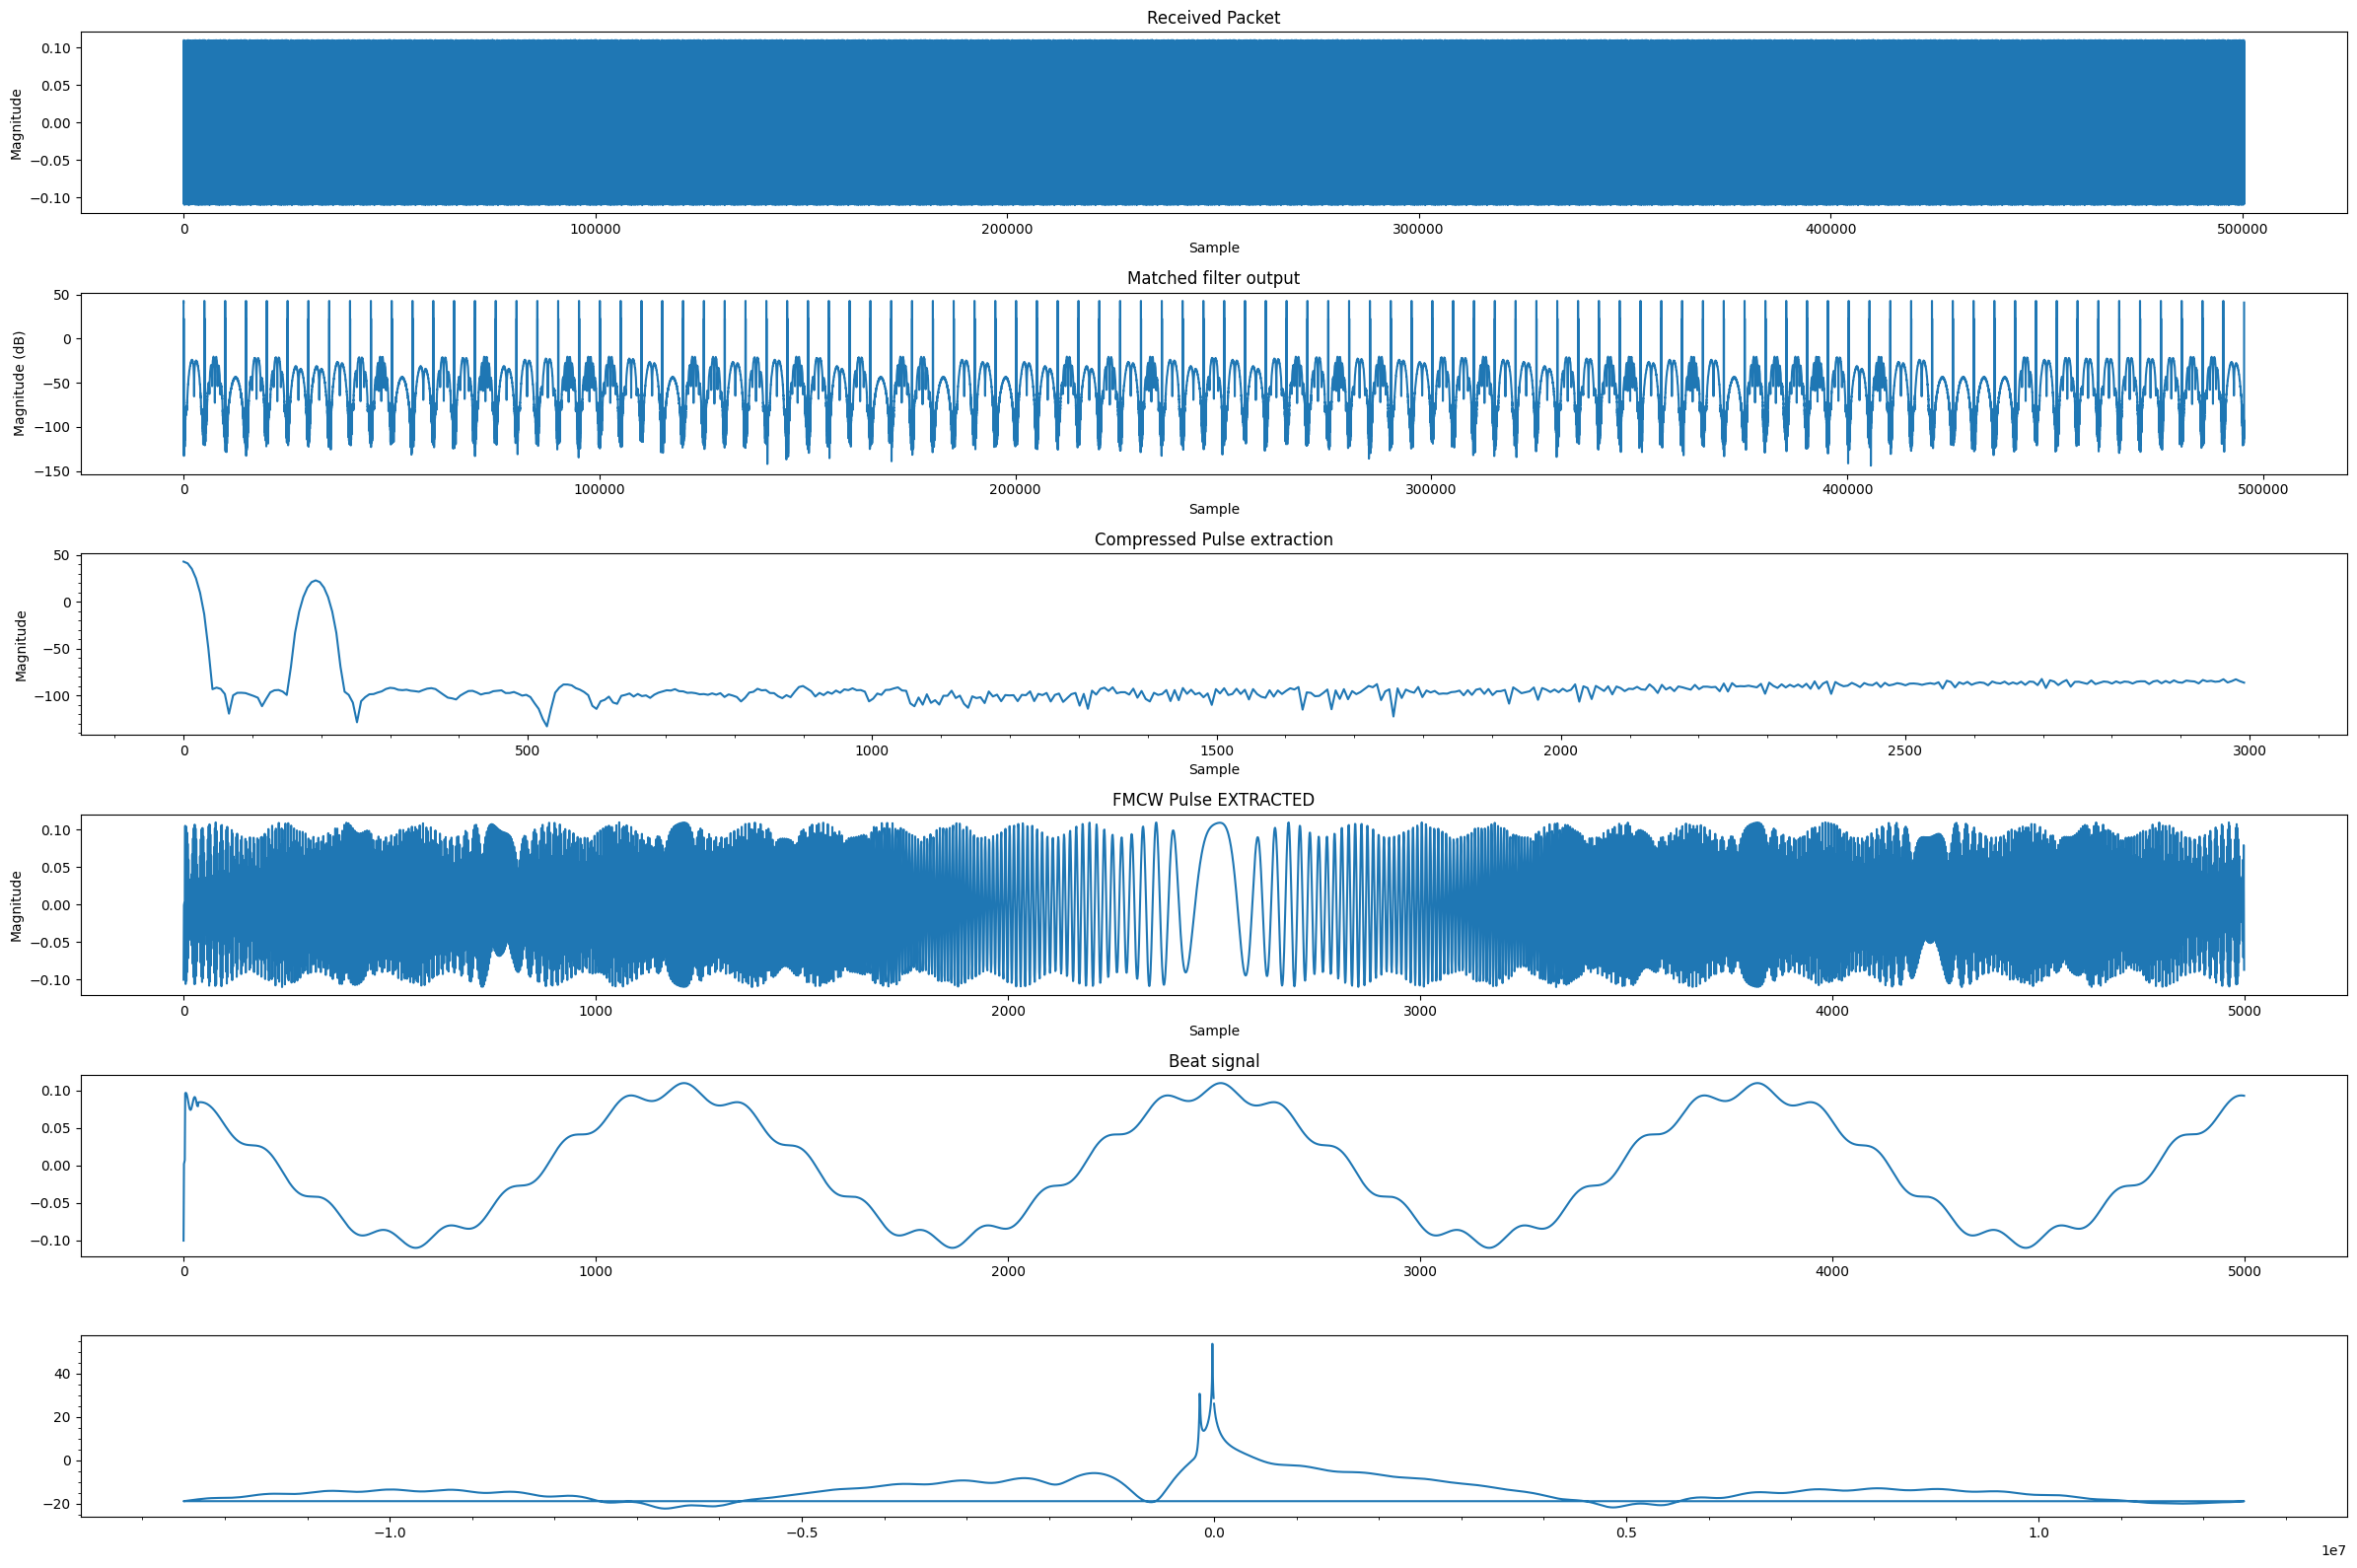

In [53]:
fs = 25e6

template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]

Pt_db = 12.5
Pt_lin = 10 ** (Pt_dbm / 10) 
Gr_db = 6
Gt_db = 6
Gr_lin = 10 ** (Gr_db / 10)
Gt_lin = 10 ** (Gt_db / 10)
fc = 2.7e9
lam = c/fc
rcs = 2.8
def get_radar_atten(R):
    Pr_lin = (Pt_lin * Gr_lin * Gt_lin * lam**2 * rcs)/((4*np.pi)**3 * R**4)
    Pr_db = 10*np.log10(Pr_lin)
    #print(f"Pt = {Pt_dbm}dBm")
    print(f"For distance {R}")
    print(f"Pr = {Pr_db+30}dBm")
    atten = np.sqrt(Pr_lin/Pt_lin)
    print(f"atten: {atten}")
    print(f"--------")
    return atten

R = 200
fb = 2*fc*R/c
print(f"Expected beat f {fb}Hz")
idx = 2*int(R/c * fs)
atten = get_radar_atten(R)
atten = 0.01

# Generate pulses
num_pulses=100
pulses_arr = []
for i in range(num_pulses):
    random_integer = np.random.randint(0, 10)
    zeros = np.zeros(random_integer).astype(np.complex128)
    pulses_arr.extend(zeros)
    pulses_arr.extend(template_signal)
pulses_arr = np.array(pulses_arr)
pulses_arr_xtalk = 0.1*pulses_arr

pulses_arr_shifted = np.zeros_like(pulses_arr)
pulses_arr_shifted[idx:] = atten*pulses_arr[:-idx]

T = 290
B = 24e6
Pn_lin = k*T*B
Pn_db = 10*np.log10(Pn_lin)
print(f"Noise power {Pn_lin} linear, {Pn_db}dB")
R_max = np.power((Pt_lin*Gt_lin*Gr_lin*lam**2 * rcs)/((4*np.pi)**3 * Pn_lin),1/4)
print(f"Theoretical max range {R_max}m")
signal_with_refl = pulses_arr_xtalk + pulses_arr_shifted + np.sqrt(Pn_lin) * (np.random.randn(len(pulses_arr)) + 1j * np.random.randn(len(pulses_arr)))

fig, axs = plt.subplots(6, 1, figsize=(24, 16))
# Received packet plot
axs[0].plot(signal_with_refl)
axs[0].set_title("Received Packet")
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Magnitude")

# Matched filter 
matched_filter = np.conjugate(template_signal[::-1])
window = kaiser(len(matched_filter), 20, sym=True)  # Choose the appropriate window function
matched_filter = matched_filter * window  # Apply the window
xcorr_data = fftconvolve(signal_with_refl, matched_filter, mode='full')
xcorr_data = xcorr_data[5000:-5000] #xcorr artifacts at start and end
data = signal_with_refl[5000:-5000]
axs[1].plot(20*np.log10(np.abs(xcorr_data)))
axs[1].set_title("Matched filter output")
axs[1].set_xlabel("Sample")
axs[1].set_ylabel("Magnitude (dB)")

# Pulse summing
pulse_matrix = []   
pulse_sum = np.zeros(end).astype(np.complex128)
ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:end]
while (len(xcorr_data)>0):
    max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
    pulse_this = data[max_idx+pulse_separation:max_idx+pulse_separation+pulse_width]
    xcorr_data = xcorr_data[pulse_width+pulse_separation:]
    pulse_matrix.append(pulse_this)


# Pulse extraction
# First max index to see where CW has started
xcorr_data = fftconvolve(signal_with_refl, matched_filter, mode='full')
xcorr_data = xcorr_data[5000:-5000] #xcorr artifacts at start and end
max_idx = np.argmax(xcorr_data[:pulse_width +pulse_separation])
xcorr_plot = 20*np.log10(np.abs(xcorr_data[max_idx:max_idx+500]))
ranges_xcorr = np.arange(len(xcorr_plot)) * c / (2*25e6)
axs[2].plot(ranges_xcorr,xcorr_plot)
#axs[2].plot(data[max_idx:max_idx+pulse_width])
axs[2].set_title("Compressed Pulse extraction")
axs[2].set_xlabel("Sample")
axs[2].set_ylabel("Magnitude")
axs[2].minorticks_on()

extracted = data[max_idx+pulse_separation:max_idx+pulse_separation+pulse_width]
extracted_sum = np.sum(pulse_matrix)

axs[3].plot(extracted)
axs[3].set_title("FMCW Pulse EXTRACTED")
axs[3].set_xlabel("Sample")
axs[3].set_ylabel("Magnitude")

# Beat signal
beat_signal = extracted * np.conj(template_signal) 
axs[4].plot(beat_signal)
axs[4].set_title("Beat signal")


# FFT for beat frequency
fft_data = np.fft.fft(beat_signal)
fft_freqs = np.fft.fftfreq(len(beat_signal),1/fs)
fft_db = 20*np.log10(np.abs(fft_data))
axs[5].plot(fft_freqs,fft_db)

midpt = len(fft_freqs)//2
fft_freqs = fft_freqs[:midpt]
fft_data = fft_data[:midpt]
fft_db = fft_db[:midpt]
end_idx = 200
#fft_freqs = fft_freqs[:end_idx]
#fft_db = fft_db[:end_idx]
#fft_data = fft_data[:-end_idx]

dR = c/(2*B)
ranges_fft = fft_freqs*dR*pulse_width/fs
#axs[5].plot(fft_freqs,fft_db)
axs[5].minorticks_on()


plt.tight_layout()
plt.show()